## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import os, glob, time, random
import matplotlib.pyplot as plt
from collections import defaultdict
from tempfile import TemporaryDirectory
from concurrent.futures import ThreadPoolExecutor

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

## Setup data dir and seed

In [2]:
data_dir = "/kaggle/input/faces-dqdp"
df_dir = "/kaggle/input/faces-dqdp/modified-cleanlab-faces-expr.csv"

In [3]:
df = pd.read_csv(df_dir)

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Classes for dataset

In [22]:
class CMUFaceDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        # User IDs in the dataset
        self.user_ids = ['an2i', 'at33', 'boland', 'bpm', 'ch4f', 'cheyer', 'choon',
                   'danieln', 'glickman', 'karyadi', 'kawamura', 'kk49', 'megak',
                   'mitchell', 'night', 'phoebe', 'saavik', 'steffi', 'sz24', 'tammo']

        # Create user_id to index mapping for faster lookups
        self.user_to_idx = {user_id: idx for idx, user_id in enumerate(self.user_ids)}

        # Scan the dataset directory structure
        self._scan_dataset()

    def _scan_dataset(self):
        """Scan the dataset directory and collect metadata without loading images."""
        # Use glob to find all PGM files (more efficient than nested loops)
        pattern = os.path.join(self.data_dir, "*/*.pgm")
        all_image_paths = glob.glob(pattern)

        exp_size = len(all_image_paths)
        
        # Initialize data structures
        self.image_paths = [None] * exp_size
        self.pose = [None] * exp_size
        self.expression = [None] * exp_size
        self.eyes = [None] * exp_size
        self.images = [None] * exp_size

        # Process files sequentially to avoid thread safety issues
        valid_idx = 0
        for img_path in all_image_paths:
            # Extract user_id from path
            parts = os.path.normpath(img_path).split(os.sep)
            user_id = parts[-2]  # Parent directory name is the user_id

            if user_id in self.user_to_idx:
                # Parse filename to extract metadata
                filename = os.path.basename(img_path)
                parts = filename.split('_')

                if len(parts) >= 4:
                    # Store metadata and path
                    self.image_paths[valid_idx] = img_path
                    self.pose[valid_idx] = parts[1]
                    self.expression[valid_idx] = parts[2]
                    self.eyes[valid_idx] = parts[3][:-4]

                    image = Image.open(img_path).convert('L')
                    if self.transform:
                        image = self.transform(image)
                    self.images[valid_idx] = image
                    valid_idx += 1

        if valid_idx < exp_size:
          self.image_paths = self.image_paths[:valid_idx]
          self.pose = self.pose[:valid_idx]
          self.expression = self.expression[:valid_idx]
          self.eyes = self.eyes[:valid_idx]
          self.images = self.images[:valid_idx]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        return self.images[idx], (self.pose[idx], self.expression[idx], self.eyes[idx])

In [23]:
class CMUFaceDatasetCleanLab(Dataset):
    def __init__(self, data_dir, transform=None, df=None, col='expression'):
        self.data_dir = data_dir
        self.transform = transform
        self.df = df
        
        # Create a mapping from image filename to new label if df is provided
        self.expression_mapping = {}
        if df is not None:
            # Convert dataframe to a dictionary for faster lookups
            self.expression_mapping = dict(zip(df['image'], df[col]))

        # User IDs in the dataset
        self.user_ids = ['an2i', 'at33', 'boland', 'bpm', 'ch4f', 'cheyer', 'choon',
                   'danieln', 'glickman', 'karyadi', 'kawamura', 'kk49', 'megak',
                   'mitchell', 'night', 'phoebe', 'saavik', 'steffi', 'sz24', 'tammo']

        # Create user_id to index mapping for faster lookups
        self.user_to_idx = {user_id: idx for idx, user_id in enumerate(self.user_ids)}

        # Scan the dataset directory structure
        self._scan_dataset()

    def _scan_dataset(self):
        """Scan the dataset directory and collect metadata without loading images."""
        # Use glob to find all PGM files (more efficient than nested loops)
        pattern = os.path.join(self.data_dir, "*/*.pgm")
        all_image_paths = glob.glob(pattern)

        exp_size = len(all_image_paths)
        
        # Initialize data structures
        self.image_paths = [None] * exp_size
        self.pose = [None] * exp_size
        self.expression = [None] * exp_size
        self.eyes = [None] * exp_size
        self.images = [None] * exp_size

        # Process files sequentially to avoid thread safety issues
        valid_idx = 0
        for img_path in all_image_paths:

            parts = os.path.normpath(img_path).split(os.sep)
            user_id = parts[-2]  # Parent directory name is the user_id
            filename = os.path.basename(img_path)

            if user_id in self.user_to_idx:
                # Parse filename to extract metadata
                parts = filename.split('_')

                if len(parts) >= 4:
                    
                    # Use the mapped expression if available, otherwise use the original
                    if filename in self.expression_mapping:
                        expression = self.expression_mapping[filename]
                    else:
                        expression = parts[2]
                        
                    # Store metadata and path
                    self.image_paths[valid_idx] = img_path
                    self.pose[valid_idx] = parts[1]
                    self.expression[valid_idx] = expression
                    self.eyes[valid_idx] = parts[3][:-4]

                    image = Image.open(img_path).convert('L')
                    if self.transform:
                        image = self.transform(image)
                    self.images[valid_idx] = image
                    valid_idx += 1

        if valid_idx < exp_size:
          self.image_paths = self.image_paths[:valid_idx]
          self.pose = self.pose[:valid_idx]
          self.expression = self.expression[:valid_idx]
          self.eyes = self.eyes[:valid_idx]
          self.images = self.images[:valid_idx]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        return self.images[idx], (self.pose[idx], self.expression[idx], self.eyes[idx])


## Classes for classifier

In [7]:
class MultitaskFaceClassifier(nn.Module):
    def __init__(self, num_poses=4, num_expressions=2, num_eye_states=2):
        super(MultitaskFaceClassifier, self).__init__()

        # Enhanced feature extraction with batch normalization
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)

        # Shared features with batch norm
        self.fc_shared = nn.Linear(128 * 8 * 8, 512)
        self.bn_shared = nn.BatchNorm1d(512)
        self.dropout_shared = nn.Dropout(0.5)

        # Enhanced task-specific heads with intermediate layers
        # Pose head - more complex for better feature discrimination
        self.pose_layers = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_poses)
        )

        # Expression head
        self.expression_layers = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_expressions)
        )

        # Eyes head
        self.eyes_layers = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_eye_states)
        )

    def forward(self, x):
        # Improved feature extraction
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 8 * 8)

        # Shared features with normalization
        features = self.fc_shared(x)
        features = self.bn_shared(features)
        features = F.relu(features)
        features = self.dropout_shared(features)

        # Task-specific outputs through enhanced heads
        pose_out = self.pose_layers(features)
        expression_out = self.expression_layers(features)
        eyes_out = self.eyes_layers(features)

        return {
            'pose': pose_out,
            'expression': expression_out,
            'eyes': eyes_out
        }, features

    def get_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        features = self.fc_shared(x)
        return features


In [8]:
class MultiTaskResNet50(nn.Module):
    def __init__(self, num_pose_classes, num_expression_classes, num_eyes_classes):
        super(MultiTaskResNet50, self).__init__()

        # Load the pretrained ResNet model
        base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # Freeze early layers to preserve pretrained features
        for param in list(base_model.parameters())[:-20]:  # Freeze all but last few layers
            param.requires_grad = False

        # Remove the final fully connected layer
        modules = list(base_model.children())[:-1]
        self.base_model = nn.Sequential(*modules)

        # Get the number of features from the base model
        num_ftrs = base_model.fc.in_features

        # Add bottleneck to reduce feature dimensionality before task-specific heads
        self.bottleneck = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # More sophisticated task-specific heads
        self.pose_fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_pose_classes)
        )

        self.expression_fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(256, num_expression_classes)
        )

        self.eyes_fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_eyes_classes)
        )

    def forward(self, x):
        # Forward pass through the base model
        x = self.base_model(x)
        # Flatten the output
        x = torch.flatten(x, 1)

        # Pass through bottleneck
        features = self.bottleneck(x)

        # Forward pass through enhanced task-specific heads
        pose_out = self.pose_fc(features)
        expression_out = self.expression_fc(features)
        eyes_out = self.eyes_fc(features)

        # Return dictionary with task outputs
        return {'pose': pose_out, 'expression': expression_out, 'eyes': eyes_out}


## Helper functions

In [9]:
def visualize_batch_samples(dataset, num_samples=8, batch_size=4):
    """Visualize a batch of samples from the dataset"""
    # Create a DataLoader with the specified batch size
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    plt.figure(figsize=(24, 5))
    for j in range(num_samples):
      # Get a single batch using next(iter())
      images, metadata = next(iter(dataloader))

      # Plot each image in the batch
      for i in range(batch_size):
        # Convert tensor to numpy for display
        if isinstance(images[i], torch.Tensor):
            img = images[i].cpu().numpy().squeeze()
            # Denormalize if needed (if your transform normalizes)
            if img.min() < 0:
                img = img * 0.5 + 0.5

        pose = metadata[0][i]
        expression = metadata[1][i]
        eyes = metadata[2][i]

        # Display the image
        plt.subplot(num_samples, batch_size, batch_size*(j) + i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{pose}; {expression}; {eyes}")
        plt.axis('off')
    plt.show()

In [10]:
def preprocess_metadata(dataset):
    """Extract and encode metadata attributes"""

    poses = ['left', 'right', 'straight', 'up']
    expressions = ['angry', 'happy', 'neutral', 'sad']
    eye_states = ['open', 'sunglasses']

    # Create mappings
    pose_to_idx = {pose: idx for idx, pose in enumerate(poses)}
    expression_to_idx = {expr: idx for idx, expr in enumerate(expressions)}
    eyes_to_idx = {eyes: idx for idx, eyes in enumerate(eye_states)}

    return {
        'pose_to_idx': pose_to_idx,
        'expression_to_idx': expression_to_idx,
        'eyes_to_idx': eyes_to_idx,
        'num_poses': len(poses),
        'num_expressions': len(expressions),
        'num_eye_states': len(eye_states)
    }

In [11]:
def train_model(model, train_loader, val_loader, metadata_info, num_epochs=10, pretrained=False):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    # Define loss function and optimizer
    pose_criterion = nn.CrossEntropyLoss()
    expression_criterion = nn.CrossEntropyLoss()
    eyes_criterion = nn.CrossEntropyLoss()

    #optimizer = optim.Adam(model.parameters(), lr=0.001)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, threshold=0.01)

    train_total_losses = []
    val_total_losses = []
    train_pose_losses = []
    train_expression_losses = []
    train_eyes_losses = []
    val_pose_losses = []
    val_expression_losses = []
    val_eyes_losses = []

    # Removed TemporaryDirectory and model saving
    since = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Train and evaluation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            # Initialize metrics for all tasks
            running_loss = 0.0
            running_loss_pose = 0.0
            running_loss_expression = 0.0
            running_loss_eyes = 0.0
            running_pose_corrects = 0
            running_expression_corrects = 0
            running_eyes_corrects = 0
            running_samples = 0

            # Process batches
            for inputs, meta in tqdm(dataloader, desc=f'{phase}'):
                inputs = inputs.to(device)

                # Convert metadata to tensors
                pose_labels = torch.tensor([metadata_info['pose_to_idx'][m] for m in meta[0]]).to(device)
                expression_labels = torch.tensor([metadata_info['expression_to_idx'][m] for m in meta[1]]).to(device)
                eyes_labels = torch.tensor([metadata_info['eyes_to_idx'][m] for m in meta[2]]).to(device)

                # Zero gradients
                optimizer.zero_grad()

                # Forward pass with gradient tracking if training
                with torch.set_grad_enabled(phase == 'train'):
                    if pretrained:
                        outputs = model(inputs)
                    else:
                        outputs, _ = model(inputs)

                    # Calculate loss for each task
                    loss_pose = pose_criterion(outputs['pose'], pose_labels)
                    loss_expression = expression_criterion(outputs['expression'], expression_labels)
                    loss_eyes = eyes_criterion(outputs['eyes'], eyes_labels)

                    # Combined loss with weight adjustments
                    loss = loss_pose + .5*loss_expression + loss_eyes

                    # Get predictions for each task
                    _, pose_preds = torch.max(outputs['pose'], 1)
                    _, expression_preds = torch.max(outputs['expression'], 1)
                    _, eyes_preds = torch.max(outputs['eyes'], 1)

                    # Backward pass and optimize if training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Update metrics
                running_loss += loss.item() * inputs.size(0)
                running_loss_pose += loss_pose.item() * inputs.size(0)
                running_loss_expression += loss_expression.item() * inputs.size(0)
                running_loss_eyes += loss_eyes.item() * inputs.size(0)

                running_pose_corrects += torch.sum(pose_preds == pose_labels.data)
                running_expression_corrects += torch.sum(expression_preds == expression_labels.data)
                running_eyes_corrects += torch.sum(eyes_preds == eyes_labels.data)

                running_samples += inputs.size(0)

            # Update scheduler if training
            if phase == 'train':
                scheduler.step()


            # Calculate epoch metrics
            epoch_loss = running_loss / running_samples
            pose_loss = running_loss_pose / running_samples
            expression_loss = running_loss_expression / running_samples
            eyes_loss = running_loss_eyes / running_samples

            pose_acc = running_pose_corrects.double() / running_samples
            expression_acc = running_expression_corrects.double() / running_samples
            eyes_acc = running_eyes_corrects.double() / running_samples

            # Display performance for all tasks
            print(f'[{phase} loss] pose: {pose_loss:.4f}; expression: {expression_loss:.4f}; eyes: {eyes_loss:.4f}; total: {epoch_loss:.4f}')
            print(f'[{phase} acc]  pose: {pose_acc:.4f}; expression: {expression_acc:.4f}; eyes: {eyes_acc:.4f}\n')

            if phase == 'val':
                val_total_losses.append(epoch_loss)
                val_pose_losses.append(pose_loss)
                val_expression_losses.append(expression_loss)
                val_eyes_losses.append(eyes_loss)

            elif phase == 'train':
                train_total_losses.append(epoch_loss)
                train_pose_losses.append(pose_loss)
                train_expression_losses.append(expression_loss)
                train_eyes_losses.append(eyes_loss)

    # Report training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # Removed model loading code

    return model, [(train_total_losses, val_total_losses), (train_pose_losses, val_pose_losses),
     (train_expression_losses, val_expression_losses), (train_eyes_losses, val_eyes_losses)]

In [12]:
def visualize_predictions(model, dataloader, metadata_info, num_images=8, pretrained=False, title=""):
    # Reverse the mapping dictionaries for display
    idx_to_pose = {idx: pose for pose, idx in metadata_info['pose_to_idx'].items()}
    idx_to_expr = {idx: expr for expr, idx in metadata_info['expression_to_idx'].items()}
    idx_to_eyes = {idx: eyes for eyes, idx in metadata_info['eyes_to_idx'].items()}

    device = next(model.parameters()).device
    was_training = model.training
    model.eval()

    images_so_far = 0
    plt.figure(figsize=(26, 7))
    plt.suptitle(title)

    # Initialize lists to accumulate all predictions and true labels
    all_true_poses = []
    all_pred_poses = []
    all_true_exprs = []
    all_pred_exprs = []
    all_true_eyes  = []
    all_pred_eyes  = []

    with torch.no_grad():
        for inputs, meta in dataloader:
            inputs = inputs.to(device)

            # Get metadata labels as tensors
            pose_labels = torch.tensor([metadata_info['pose_to_idx'][m] for m in meta[0]]).to(device)
            expr_labels = torch.tensor([metadata_info['expression_to_idx'][m] for m in meta[1]]).to(device)
            eyes_labels = torch.tensor([metadata_info['eyes_to_idx'][m] for m in meta[2]]).to(device)

            # Forward pass
            if pretrained:
                outputs = model(inputs)
            else:
                outputs, _ = model(inputs)

            # Get predictions for all tasks
            _, pose_preds = torch.max(outputs['pose'], 1)
            _, expr_preds = torch.max(outputs['expression'], 1)
            _, eyes_preds = torch.max(outputs['eyes'], 1)

            true_poses = [idx_to_pose[pose_labels[j].item()] for j in range(len(pose_labels))]
            pred_poses = [idx_to_pose[pose_preds[j].item()] for j in range(len(pose_preds))]

            true_exprs = [idx_to_expr[expr_labels[j].item()] for j in range(len(expr_labels))]
            pred_exprs = [idx_to_expr[expr_preds[j].item()] for j in range(len(expr_preds))]

            true_eyes = [idx_to_eyes[eyes_labels[j].item()] for j in range(len(eyes_labels))]
            pred_eyes = [idx_to_eyes[eyes_preds[j].item()] for j in range(len(eyes_preds))]

            # Append batch results to the accumulated lists
            all_true_poses.extend(true_poses)
            all_pred_poses.extend(pred_poses)
            all_true_exprs.extend(true_exprs)
            all_pred_exprs.extend(pred_exprs)
            all_true_eyes.extend(true_eyes)
            all_pred_eyes.extend(pred_eyes)

            # Only do visualization if we haven't reached the image limit
            if images_so_far < num_images:
                # Plot images with predictions
                for j in range(inputs.size()[0]):
                    if images_so_far >= num_images:
                        break  # Stop visualization but continue prediction accumulation

                    images_so_far += 1

                    # Create subplot
                    plt.subplot(2, 8, images_so_far)

                    # Convert tensor to image and display
                    img = inputs[j].cpu().permute(1, 2, 0).numpy()
                    img = img * 0.5 + 0.5  # Denormalize
                    plt.imshow(img, cmap='gray')

                    # Get predicted and true values
                    true_pose = idx_to_pose[pose_labels[j].item()]
                    pred_pose = idx_to_pose[pose_preds[j].item()]

                    true_expr = idx_to_expr[expr_labels[j].item()]
                    pred_expr = idx_to_expr[expr_preds[j].item()]

                    true_eye = idx_to_eyes[eyes_labels[j].item()]
                    pred_eye = idx_to_eyes[eyes_preds[j].item()]

                    # Color coding for correct/incorrect predictions
                    pose_color = 'green' if pred_pose == true_pose else 'red'
                    expr_color = 'green' if pred_expr == true_expr else 'red'
                    eye_color = 'green' if pred_eye == true_eye else 'red'

                    # Create title with all predictions
                    title = f"{true_pose} {true_expr} {true_eye}\n"
                    plt.text(0, -2, f"{pred_pose}", color=pose_color, fontsize=12)
                    plt.text(21, -2, f"{pred_expr}", color=expr_color, fontsize=12)
                    plt.text(41, -2, f"{pred_eye}", color=eye_color, fontsize=12)

                    plt.title(title)
                    plt.axis('off')

    # Set model back to its original training state
    model.train(mode=was_training)

    # Return accumulated results from all batches
    return [(all_true_poses, all_pred_poses), (all_true_exprs, all_pred_exprs), (all_true_eyes, all_pred_eyes)]

In [13]:
def plot_losses(losses, title=""):
    plt.figure(figsize=(24, 10))
    plt.suptitle(title)
    for i,j in zip(range(len(losses)), ['total', 'pose', 'expression', 'eyes']):
      plt.subplot(2,2,i+1)
      plt.grid('True')
      plt.plot(range(1,num_epochs+1),losses[i][0], color='red', label='Training Loss')
      plt.plot(range(1,num_epochs+1),losses[i][1], color='black', label='Validation Loss')
      plt.title(f"{j} loss")
      plt.xlabel('Epochs')
      plt.xticks(range(1,num_epochs+1))
      plt.ylabel('Loss')
      plt.legend(loc='upper right')

In [14]:
def plot_cf_matrix(pred_true, title=""):
  plt.figure(figsize=(24, 5))
  plt.suptitle(title)
  for i,j in zip(range(len(pred_true)), ['pose', 'expression', 'eyes']):
    plt.subplot(1,3,i+1)
    cm = confusion_matrix(pred_true[i][0], pred_true[i][1], labels = np.unique(pred_true[i][0]))
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    sns.heatmap(cm, xticklabels=np.unique(pred_true[i][0]), yticklabels=np.unique(pred_true[i][0]),
                annot=True, fmt='d', cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(j + f" [{accuracy:.2%}]")

## Initial Setup

In [15]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_ft = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x)
])

In [26]:
dataset = CMUFaceDataset(data_dir=data_dir, transform=transform)
dataset_ft = CMUFaceDataset(data_dir=data_dir, transform=transform_ft)

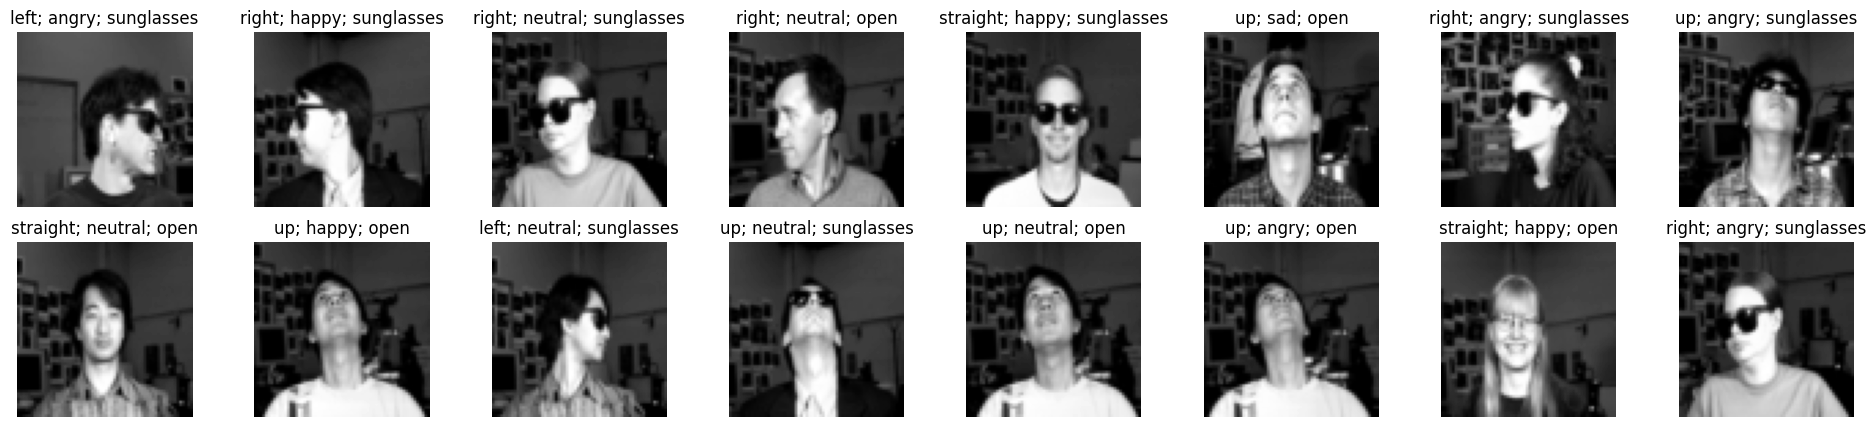

In [27]:
visualize_batch_samples(dataset, num_samples=2, batch_size=8)

In [29]:
metadata_info = preprocess_metadata(dataset)
metadata_info

{'pose_to_idx': {'left': 0, 'right': 1, 'straight': 2, 'up': 3},
 'expression_to_idx': {'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3},
 'eyes_to_idx': {'open': 0, 'sunglasses': 1},
 'num_poses': 4,
 'num_expressions': 4,
 'num_eye_states': 2}

In [30]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataset_ft, val_dataset_ft = random_split(dataset_ft, [train_size, val_size])

num_epochs = 20

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

train_loader_ft = DataLoader(train_dataset_ft, batch_size=32, shuffle=True)
val_loader_ft = DataLoader(val_dataset_ft, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## CNN Classifier

In [31]:
# Initialize model
model = MultitaskFaceClassifier(
    num_poses=metadata_info['num_poses'],
    num_expressions=metadata_info['num_expressions'],
    num_eye_states=metadata_info['num_eye_states']
).to(device)

In [32]:
# Train model
trained_model, losses = train_model(model, train_loader, val_loader, metadata_info, num_epochs=num_epochs)

Using device: cuda

Epoch 1/20
----------


train: 100%|██████████| 16/16 [00:01<00:00, 14.64it/s]


[train loss] pose: 1.3788; expression: 1.5655; eyes: 0.7214; total: 2.8830
[train acc]  pose: 0.3347; expression: 0.2224; eyes: 0.5230



val: 100%|██████████| 4/4 [00:00<00:00, 165.38it/s]


[val loss] pose: 1.3990; expression: 1.3763; eyes: 0.6917; total: 2.7789
[val acc]  pose: 0.1840; expression: 0.2640; eyes: 0.5120

Epoch 2/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 121.13it/s]


[train loss] pose: 1.0396; expression: 1.5115; eyes: 0.6156; total: 2.4110
[train acc]  pose: 0.6232; expression: 0.2725; eyes: 0.6693



val: 100%|██████████| 4/4 [00:00<00:00, 374.57it/s]


[val loss] pose: 1.1682; expression: 1.3852; eyes: 0.6495; total: 2.5103
[val acc]  pose: 0.6480; expression: 0.2560; eyes: 0.5120

Epoch 3/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 124.81it/s]


[train loss] pose: 0.8542; expression: 1.4828; eyes: 0.5338; total: 2.1294
[train acc]  pose: 0.7695; expression: 0.2665; eyes: 0.7515



val: 100%|██████████| 4/4 [00:00<00:00, 380.92it/s]


[val loss] pose: 0.8471; expression: 1.4079; eyes: 0.5184; total: 2.0695
[val acc]  pose: 0.8160; expression: 0.1840; eyes: 0.7600

Epoch 4/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 124.07it/s]


[train loss] pose: 0.7452; expression: 1.4889; eyes: 0.4635; total: 1.9532
[train acc]  pose: 0.8096; expression: 0.2625; eyes: 0.8257



val: 100%|██████████| 4/4 [00:00<00:00, 355.52it/s]


[val loss] pose: 0.6746; expression: 1.4096; eyes: 0.4086; total: 1.7880
[val acc]  pose: 0.8800; expression: 0.1920; eyes: 0.8560

Epoch 5/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 121.91it/s]


[train loss] pose: 0.6002; expression: 1.4773; eyes: 0.3975; total: 1.7363
[train acc]  pose: 0.8798; expression: 0.2204; eyes: 0.8677



val: 100%|██████████| 4/4 [00:00<00:00, 366.43it/s]


[val loss] pose: 0.5388; expression: 1.4113; eyes: 0.3265; total: 1.5709
[val acc]  pose: 0.9040; expression: 0.1600; eyes: 0.9520

Epoch 6/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 123.15it/s]


[train loss] pose: 0.5172; expression: 1.4563; eyes: 0.3313; total: 1.5766
[train acc]  pose: 0.8898; expression: 0.2645; eyes: 0.8858



val: 100%|██████████| 4/4 [00:00<00:00, 378.22it/s]


[val loss] pose: 0.4685; expression: 1.4145; eyes: 0.2739; total: 1.4496
[val acc]  pose: 0.9440; expression: 0.1680; eyes: 0.9680

Epoch 7/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 123.30it/s]


[train loss] pose: 0.4503; expression: 1.4329; eyes: 0.2874; total: 1.4541
[train acc]  pose: 0.9259; expression: 0.2725; eyes: 0.9078



val: 100%|██████████| 4/4 [00:00<00:00, 369.05it/s]


[val loss] pose: 0.3758; expression: 1.4235; eyes: 0.2381; total: 1.3257
[val acc]  pose: 0.9680; expression: 0.1520; eyes: 0.9600

Epoch 8/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 119.54it/s]


[train loss] pose: 0.4346; expression: 1.4205; eyes: 0.2547; total: 1.3996
[train acc]  pose: 0.9098; expression: 0.2886; eyes: 0.9399



val: 100%|██████████| 4/4 [00:00<00:00, 347.78it/s]


[val loss] pose: 0.3719; expression: 1.4158; eyes: 0.2342; total: 1.3140
[val acc]  pose: 0.9600; expression: 0.1440; eyes: 0.9440

Epoch 9/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 122.39it/s]


[train loss] pose: 0.3945; expression: 1.4344; eyes: 0.2727; total: 1.3844
[train acc]  pose: 0.9379; expression: 0.2826; eyes: 0.9339



val: 100%|██████████| 4/4 [00:00<00:00, 381.09it/s]


[val loss] pose: 0.3621; expression: 1.4158; eyes: 0.2342; total: 1.3041
[val acc]  pose: 0.9600; expression: 0.1600; eyes: 0.9360

Epoch 10/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 122.58it/s]


[train loss] pose: 0.3919; expression: 1.4165; eyes: 0.2483; total: 1.3485
[train acc]  pose: 0.9319; expression: 0.3026; eyes: 0.9419



val: 100%|██████████| 4/4 [00:00<00:00, 374.08it/s]


[val loss] pose: 0.3584; expression: 1.4192; eyes: 0.2269; total: 1.2949
[val acc]  pose: 0.9600; expression: 0.1520; eyes: 0.9520

Epoch 11/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 121.72it/s]


[train loss] pose: 0.4244; expression: 1.4551; eyes: 0.2423; total: 1.3942
[train acc]  pose: 0.9018; expression: 0.2826; eyes: 0.9459



val: 100%|██████████| 4/4 [00:00<00:00, 377.19it/s]


[val loss] pose: 0.3470; expression: 1.4199; eyes: 0.2292; total: 1.2862
[val acc]  pose: 0.9680; expression: 0.1760; eyes: 0.9360

Epoch 12/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 123.83it/s]


[train loss] pose: 0.3752; expression: 1.4227; eyes: 0.2521; total: 1.3386
[train acc]  pose: 0.9439; expression: 0.2906; eyes: 0.9218



val: 100%|██████████| 4/4 [00:00<00:00, 395.19it/s]


[val loss] pose: 0.3438; expression: 1.4176; eyes: 0.2125; total: 1.2650
[val acc]  pose: 0.9760; expression: 0.1760; eyes: 0.9760

Epoch 13/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 125.57it/s]


[train loss] pose: 0.3708; expression: 1.4480; eyes: 0.2046; total: 1.2994
[train acc]  pose: 0.9459; expression: 0.2405; eyes: 0.9659



val: 100%|██████████| 4/4 [00:00<00:00, 386.91it/s]


[val loss] pose: 0.3398; expression: 1.4206; eyes: 0.2104; total: 1.2605
[val acc]  pose: 0.9600; expression: 0.1680; eyes: 0.9760

Epoch 14/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 122.58it/s]


[train loss] pose: 0.3703; expression: 1.4497; eyes: 0.2329; total: 1.3280
[train acc]  pose: 0.9419; expression: 0.2745; eyes: 0.9379



val: 100%|██████████| 4/4 [00:00<00:00, 388.01it/s]


[val loss] pose: 0.3286; expression: 1.4188; eyes: 0.2022; total: 1.2401
[val acc]  pose: 0.9760; expression: 0.1760; eyes: 0.9760

Epoch 15/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 123.09it/s]


[train loss] pose: 0.3588; expression: 1.4372; eyes: 0.2150; total: 1.2924
[train acc]  pose: 0.9599; expression: 0.2465; eyes: 0.9519



val: 100%|██████████| 4/4 [00:00<00:00, 381.62it/s]


[val loss] pose: 0.3282; expression: 1.4198; eyes: 0.2049; total: 1.2430
[val acc]  pose: 0.9680; expression: 0.1680; eyes: 0.9760

Epoch 16/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 122.91it/s]


[train loss] pose: 0.3437; expression: 1.4455; eyes: 0.2243; total: 1.2907
[train acc]  pose: 0.9619; expression: 0.2585; eyes: 0.9459



val: 100%|██████████| 4/4 [00:00<00:00, 384.29it/s]


[val loss] pose: 0.3287; expression: 1.4211; eyes: 0.2001; total: 1.2392
[val acc]  pose: 0.9840; expression: 0.1680; eyes: 0.9760

Epoch 17/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 124.57it/s]


[train loss] pose: 0.3395; expression: 1.4487; eyes: 0.2258; total: 1.2898
[train acc]  pose: 0.9559; expression: 0.2725; eyes: 0.9399



val: 100%|██████████| 4/4 [00:00<00:00, 381.17it/s]


[val loss] pose: 0.3302; expression: 1.4188; eyes: 0.2069; total: 1.2465
[val acc]  pose: 0.9760; expression: 0.1840; eyes: 0.9760

Epoch 18/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 123.27it/s]


[train loss] pose: 0.3618; expression: 1.4050; eyes: 0.2276; total: 1.2920
[train acc]  pose: 0.9459; expression: 0.3307; eyes: 0.9379



val: 100%|██████████| 4/4 [00:00<00:00, 363.99it/s]


[val loss] pose: 0.3280; expression: 1.4164; eyes: 0.2031; total: 1.2393
[val acc]  pose: 0.9840; expression: 0.1520; eyes: 0.9760

Epoch 19/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 123.67it/s]


[train loss] pose: 0.3763; expression: 1.4224; eyes: 0.2303; total: 1.3178
[train acc]  pose: 0.9459; expression: 0.2946; eyes: 0.9439



val: 100%|██████████| 4/4 [00:00<00:00, 367.61it/s]


[val loss] pose: 0.3208; expression: 1.4180; eyes: 0.2005; total: 1.2303
[val acc]  pose: 0.9840; expression: 0.1680; eyes: 0.9760

Epoch 20/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 124.41it/s]


[train loss] pose: 0.3553; expression: 1.4135; eyes: 0.2185; total: 1.2806
[train acc]  pose: 0.9499; expression: 0.3086; eyes: 0.9519



val: 100%|██████████| 4/4 [00:00<00:00, 382.45it/s]

[val loss] pose: 0.3145; expression: 1.4221; eyes: 0.1984; total: 1.2239
[val acc]  pose: 0.9760; expression: 0.1680; eyes: 0.9760

Training complete in 0m 4s


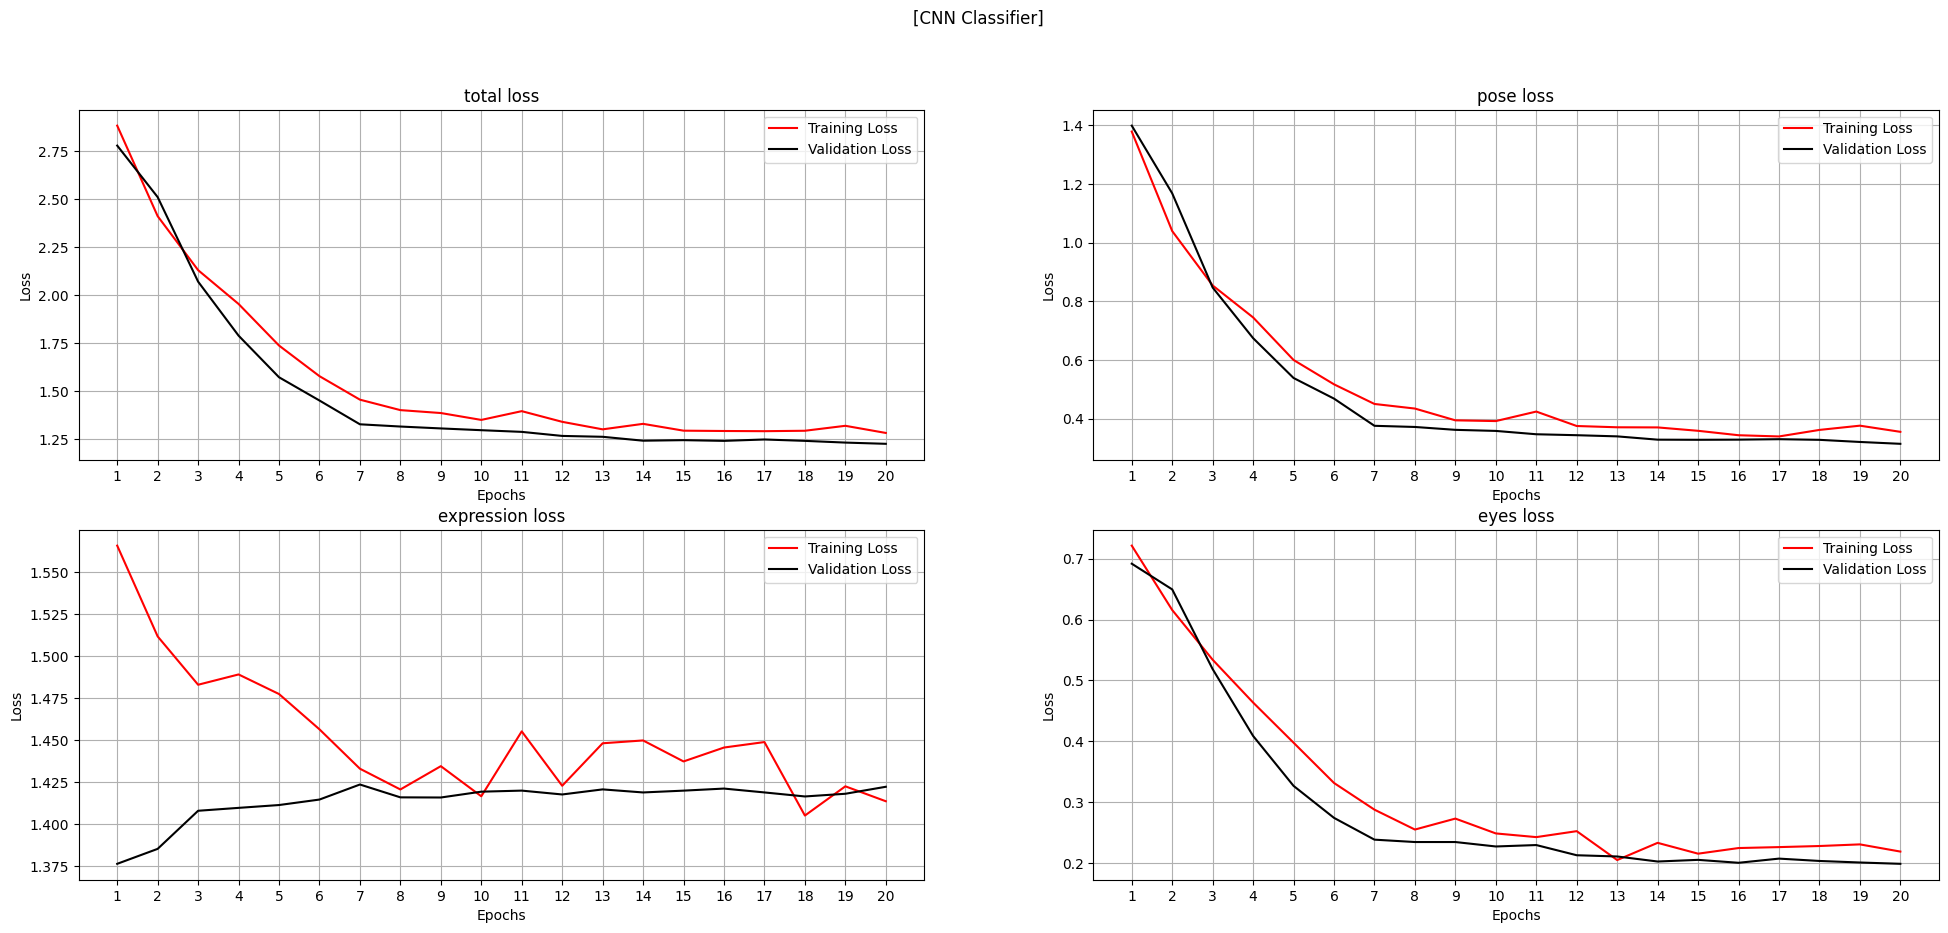

In [33]:
plot_losses(losses, title="[CNN Classifier]")

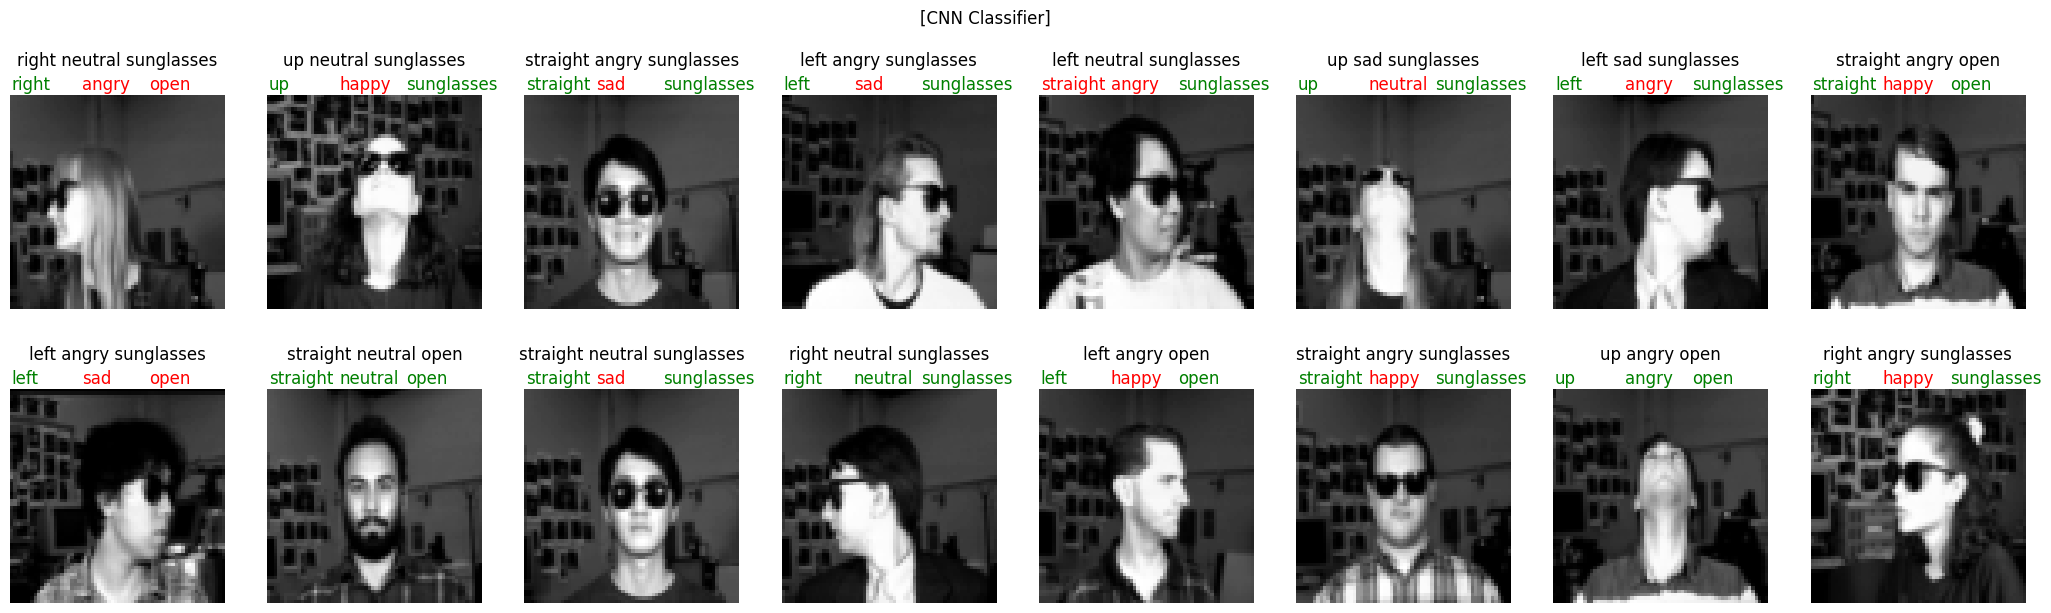

In [34]:
pred_true = visualize_predictions(trained_model, val_loader, metadata_info, num_images=16, title="[CNN Classifier]")

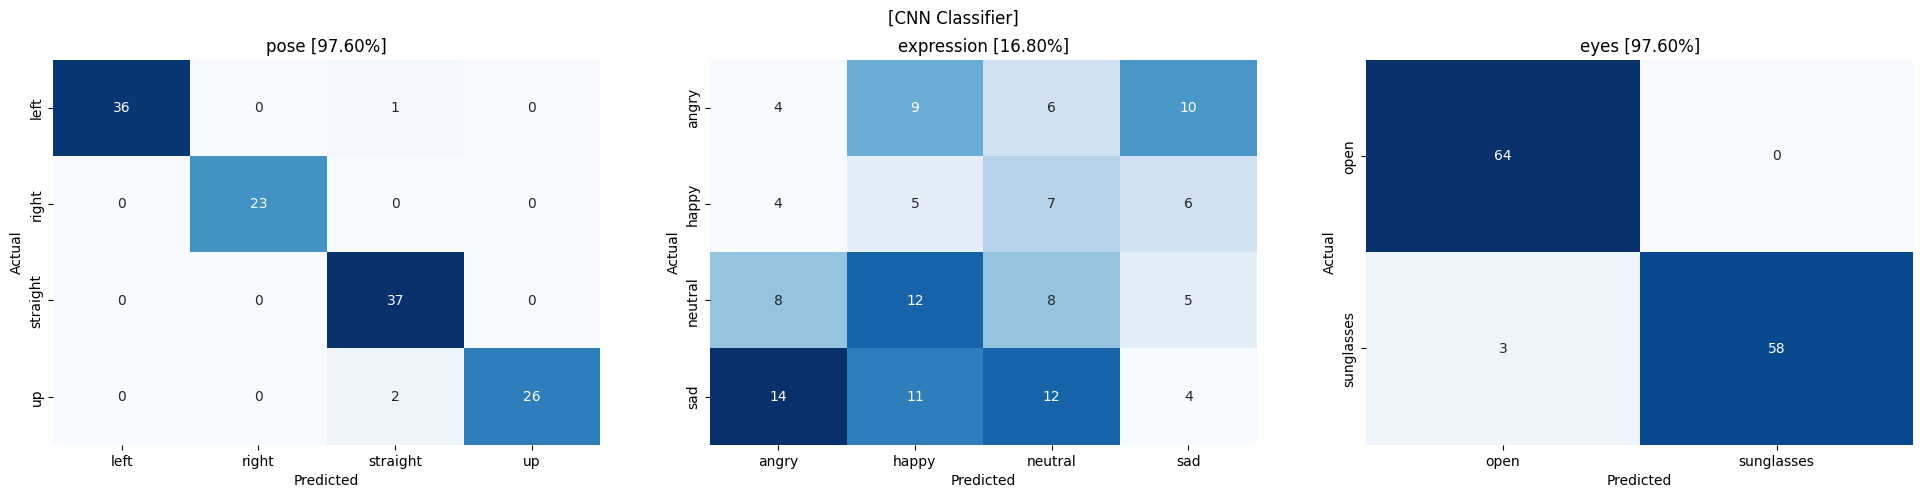

In [35]:
plot_cf_matrix(pred_true, title="[CNN Classifier]")

## ResNet50 Classifier

In [36]:
# Initialize model
model_ft = MultiTaskResNet50(
    metadata_info['num_poses'],
    metadata_info['num_expressions'],
    metadata_info['num_eye_states']
).to(device)

# Train model
trained_model_ft, losses_ft = train_model(model_ft, train_loader_ft, val_loader_ft, metadata_info, num_epochs=num_epochs, pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 94.1MB/s]


Using device: cuda

Epoch 1/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 31.07it/s]


[train loss] pose: 1.4540; expression: 1.5437; eyes: 0.7372; total: 2.9630
[train acc]  pose: 0.2665; expression: 0.2204; eyes: 0.5251



val: 100%|██████████| 4/4 [00:00<00:00, 61.38it/s]


[val loss] pose: 1.3753; expression: 1.3935; eyes: 0.6868; total: 2.7588
[val acc]  pose: 0.2720; expression: 0.2320; eyes: 0.5360

Epoch 2/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.18it/s]


[train loss] pose: 1.3555; expression: 1.4738; eyes: 0.6713; total: 2.7637
[train acc]  pose: 0.3327; expression: 0.2625; eyes: 0.5892



val: 100%|██████████| 4/4 [00:00<00:00, 87.11it/s]


[val loss] pose: 1.3883; expression: 1.4260; eyes: 0.6596; total: 2.7609
[val acc]  pose: 0.3360; expression: 0.2080; eyes: 0.6240

Epoch 3/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.26it/s]


[train loss] pose: 1.2750; expression: 1.5092; eyes: 0.6454; total: 2.6751
[train acc]  pose: 0.4228; expression: 0.2204; eyes: 0.6253



val: 100%|██████████| 4/4 [00:00<00:00, 88.81it/s]


[val loss] pose: 1.3412; expression: 1.4193; eyes: 0.6504; total: 2.7012
[val acc]  pose: 0.3520; expression: 0.2160; eyes: 0.6160

Epoch 4/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.27it/s]


[train loss] pose: 1.1632; expression: 1.4904; eyes: 0.6259; total: 2.5343
[train acc]  pose: 0.5010; expression: 0.2385; eyes: 0.6553



val: 100%|██████████| 4/4 [00:00<00:00, 88.37it/s]


[val loss] pose: 1.2695; expression: 1.3984; eyes: 0.6120; total: 2.5807
[val acc]  pose: 0.4480; expression: 0.2400; eyes: 0.6720

Epoch 5/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.05it/s]


[train loss] pose: 1.0695; expression: 1.4532; eyes: 0.5468; total: 2.3429
[train acc]  pose: 0.6012; expression: 0.2665; eyes: 0.7234



val: 100%|██████████| 4/4 [00:00<00:00, 88.22it/s]


[val loss] pose: 1.1306; expression: 1.4240; eyes: 0.5738; total: 2.4164
[val acc]  pose: 0.5840; expression: 0.1760; eyes: 0.7200

Epoch 6/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.20it/s]


[train loss] pose: 0.9856; expression: 1.4044; eyes: 0.5151; total: 2.2030
[train acc]  pose: 0.6293; expression: 0.2966; eyes: 0.7635



val: 100%|██████████| 4/4 [00:00<00:00, 88.48it/s]


[val loss] pose: 1.0084; expression: 1.4297; eyes: 0.5382; total: 2.2614
[val acc]  pose: 0.6960; expression: 0.2000; eyes: 0.7280

Epoch 7/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.18it/s]


[train loss] pose: 0.9088; expression: 1.4201; eyes: 0.4693; total: 2.0882
[train acc]  pose: 0.6874; expression: 0.3126; eyes: 0.7776



val: 100%|██████████| 4/4 [00:00<00:00, 88.55it/s]


[val loss] pose: 0.9111; expression: 1.4303; eyes: 0.4967; total: 2.1229
[val acc]  pose: 0.7120; expression: 0.2000; eyes: 0.7600

Epoch 8/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.22it/s]


[train loss] pose: 0.8414; expression: 1.4391; eyes: 0.4634; total: 2.0244
[train acc]  pose: 0.7214; expression: 0.3006; eyes: 0.7936



val: 100%|██████████| 4/4 [00:00<00:00, 88.90it/s]


[val loss] pose: 0.8978; expression: 1.4356; eyes: 0.4885; total: 2.1041
[val acc]  pose: 0.7280; expression: 0.1920; eyes: 0.7600

Epoch 9/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.38it/s]


[train loss] pose: 0.8657; expression: 1.4436; eyes: 0.4759; total: 2.0635
[train acc]  pose: 0.7074; expression: 0.2986; eyes: 0.7876



val: 100%|██████████| 4/4 [00:00<00:00, 88.72it/s]


[val loss] pose: 0.8845; expression: 1.4360; eyes: 0.4869; total: 2.0894
[val acc]  pose: 0.7200; expression: 0.2000; eyes: 0.7600

Epoch 10/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.23it/s]


[train loss] pose: 0.8280; expression: 1.4113; eyes: 0.4413; total: 1.9750
[train acc]  pose: 0.7275; expression: 0.3166; eyes: 0.8136



val: 100%|██████████| 4/4 [00:00<00:00, 89.25it/s]


[val loss] pose: 0.9135; expression: 1.4346; eyes: 0.4907; total: 2.1215
[val acc]  pose: 0.7200; expression: 0.1840; eyes: 0.7440

Epoch 11/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.35it/s]


[train loss] pose: 0.8080; expression: 1.4084; eyes: 0.4565; total: 1.9687
[train acc]  pose: 0.7555; expression: 0.2926; eyes: 0.7876



val: 100%|██████████| 4/4 [00:00<00:00, 88.94it/s]


[val loss] pose: 0.8881; expression: 1.4381; eyes: 0.4853; total: 2.0925
[val acc]  pose: 0.7440; expression: 0.1680; eyes: 0.7760

Epoch 12/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.21it/s]


[train loss] pose: 0.7922; expression: 1.4106; eyes: 0.4535; total: 1.9509
[train acc]  pose: 0.7435; expression: 0.2946; eyes: 0.7976



val: 100%|██████████| 4/4 [00:00<00:00, 87.77it/s]


[val loss] pose: 0.8775; expression: 1.4382; eyes: 0.4839; total: 2.0806
[val acc]  pose: 0.7360; expression: 0.1920; eyes: 0.7600

Epoch 13/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.23it/s]


[train loss] pose: 0.8023; expression: 1.3791; eyes: 0.4240; total: 1.9158
[train acc]  pose: 0.7455; expression: 0.3367; eyes: 0.8257



val: 100%|██████████| 4/4 [00:00<00:00, 88.62it/s]


[val loss] pose: 0.8720; expression: 1.4365; eyes: 0.4857; total: 2.0759
[val acc]  pose: 0.7120; expression: 0.1680; eyes: 0.7520

Epoch 14/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.10it/s]


[train loss] pose: 0.8019; expression: 1.4339; eyes: 0.4265; total: 1.9454
[train acc]  pose: 0.7435; expression: 0.2866; eyes: 0.8257



val: 100%|██████████| 4/4 [00:00<00:00, 87.70it/s]


[val loss] pose: 0.8679; expression: 1.4350; eyes: 0.4782; total: 2.0637
[val acc]  pose: 0.7280; expression: 0.1920; eyes: 0.7520

Epoch 15/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.16it/s]


[train loss] pose: 0.7993; expression: 1.3753; eyes: 0.4683; total: 1.9552
[train acc]  pose: 0.7475; expression: 0.3287; eyes: 0.7896



val: 100%|██████████| 4/4 [00:00<00:00, 88.68it/s]


[val loss] pose: 0.8689; expression: 1.4409; eyes: 0.4773; total: 2.0667
[val acc]  pose: 0.7680; expression: 0.1840; eyes: 0.7600

Epoch 16/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.20it/s]


[train loss] pose: 0.7818; expression: 1.3769; eyes: 0.4444; total: 1.9146
[train acc]  pose: 0.7355; expression: 0.3427; eyes: 0.8096



val: 100%|██████████| 4/4 [00:00<00:00, 88.50it/s]


[val loss] pose: 0.8717; expression: 1.4347; eyes: 0.4734; total: 2.0624
[val acc]  pose: 0.7600; expression: 0.2000; eyes: 0.7600

Epoch 17/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.23it/s]


[train loss] pose: 0.7734; expression: 1.3984; eyes: 0.4613; total: 1.9339
[train acc]  pose: 0.7555; expression: 0.3086; eyes: 0.7996



val: 100%|██████████| 4/4 [00:00<00:00, 88.51it/s]


[val loss] pose: 0.8612; expression: 1.4371; eyes: 0.4847; total: 2.0644
[val acc]  pose: 0.7280; expression: 0.1920; eyes: 0.7680

Epoch 18/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 40.28it/s]


[train loss] pose: 0.7697; expression: 1.4059; eyes: 0.4459; total: 1.9185
[train acc]  pose: 0.7355; expression: 0.2946; eyes: 0.7996



val: 100%|██████████| 4/4 [00:00<00:00, 83.10it/s]


[val loss] pose: 0.8850; expression: 1.4383; eyes: 0.4830; total: 2.0871
[val acc]  pose: 0.7120; expression: 0.1200; eyes: 0.7680

Epoch 19/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 38.78it/s]


[train loss] pose: 0.7625; expression: 1.4049; eyes: 0.4093; total: 1.8742
[train acc]  pose: 0.7776; expression: 0.3166; eyes: 0.8397



val: 100%|██████████| 4/4 [00:00<00:00, 87.83it/s]


[val loss] pose: 0.8894; expression: 1.4377; eyes: 0.4839; total: 2.0921
[val acc]  pose: 0.7280; expression: 0.1440; eyes: 0.7840

Epoch 20/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 40.90it/s]


[train loss] pose: 0.7889; expression: 1.4051; eyes: 0.4563; total: 1.9477
[train acc]  pose: 0.7515; expression: 0.2846; eyes: 0.8116



val: 100%|██████████| 4/4 [00:00<00:00, 88.31it/s]

[val loss] pose: 0.8844; expression: 1.4430; eyes: 0.4838; total: 2.0897
[val acc]  pose: 0.7360; expression: 0.2080; eyes: 0.7680

Training complete in 0m 9s


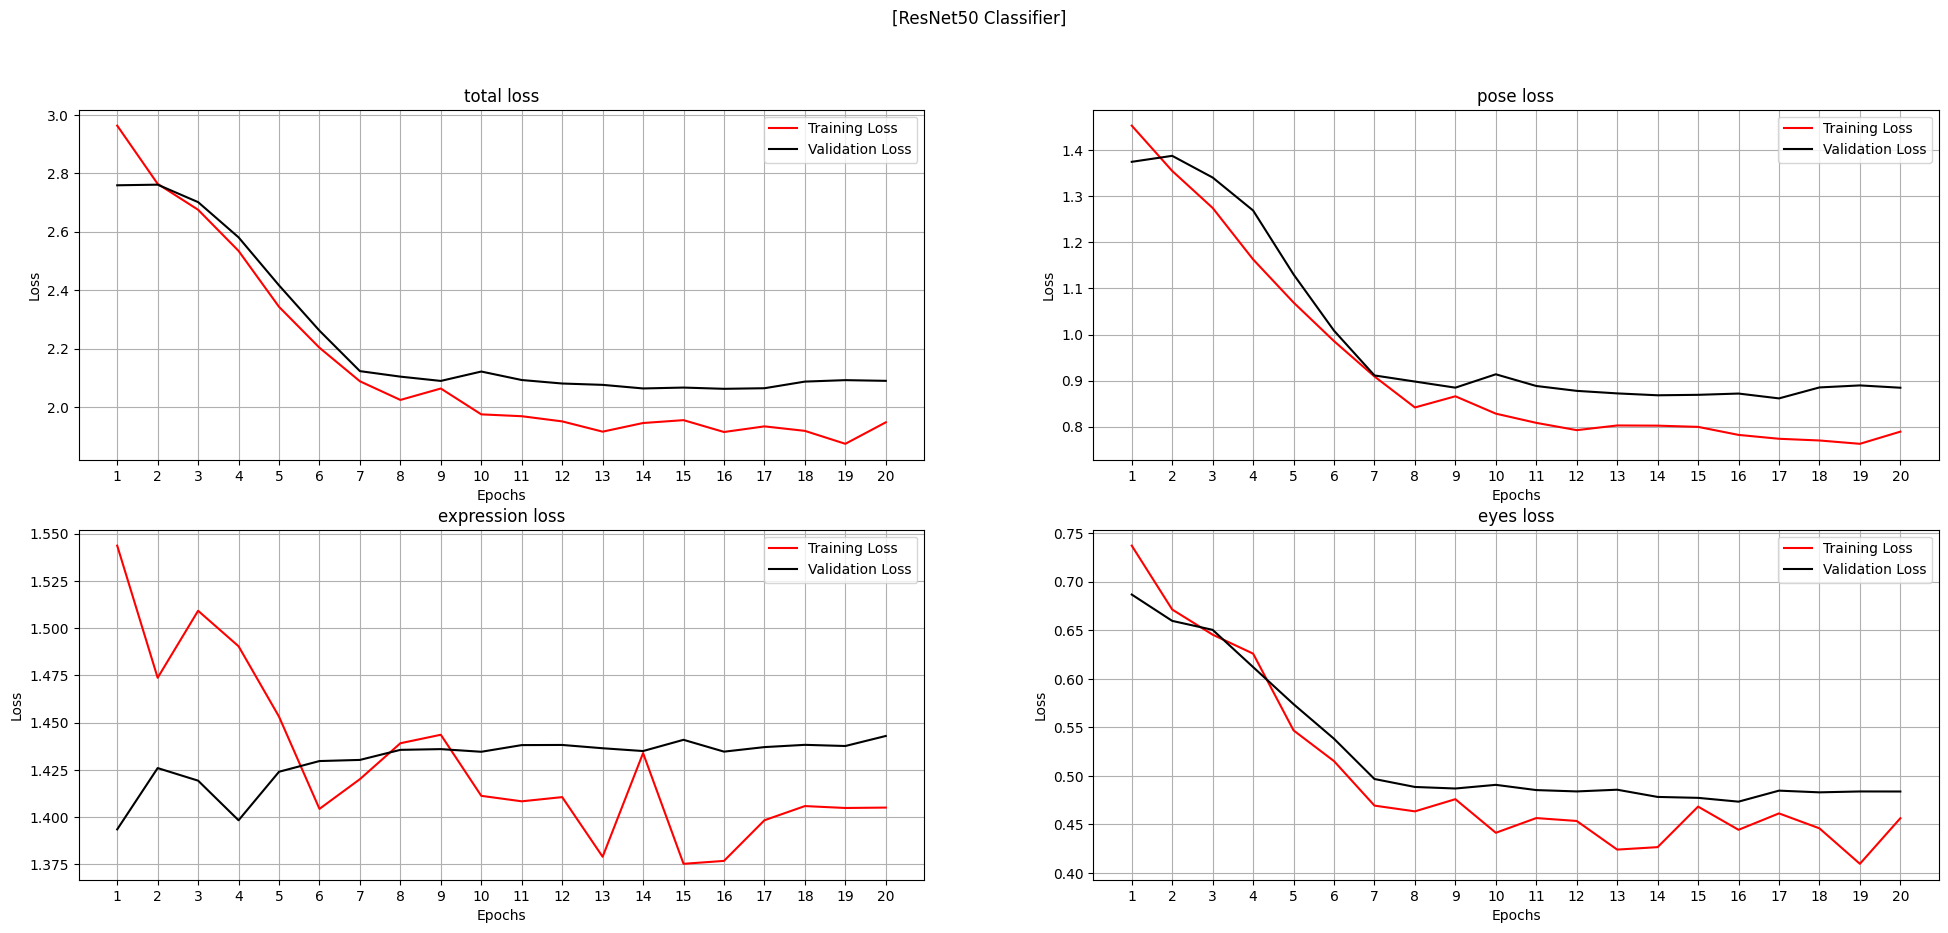

In [37]:
plot_losses(losses_ft, title="[ResNet50 Classifier]")

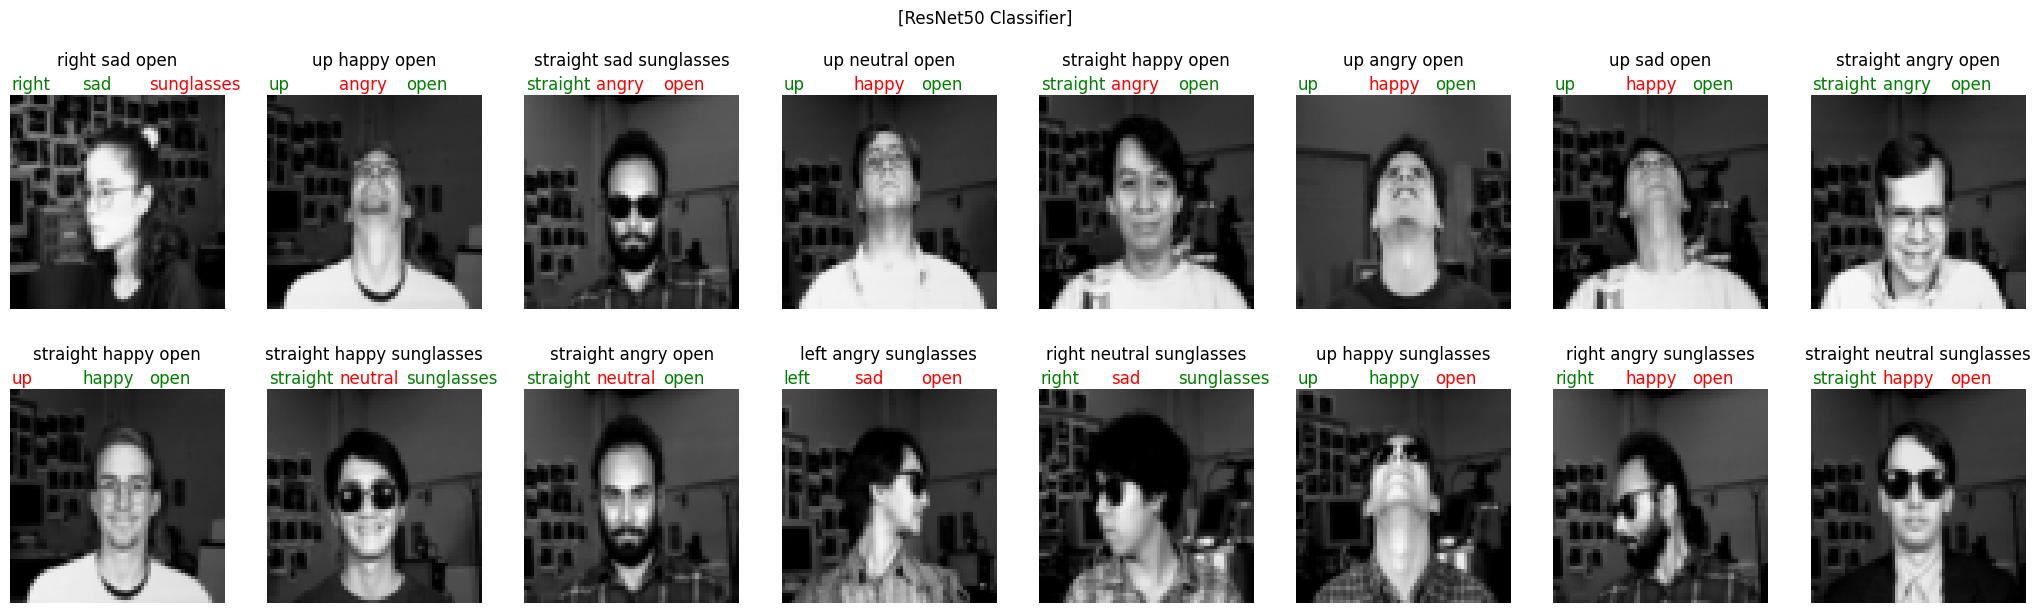

In [38]:
pred_true_ft = visualize_predictions(trained_model_ft, val_loader_ft, metadata_info, num_images=16, pretrained=True, title="[ResNet50 Classifier]")

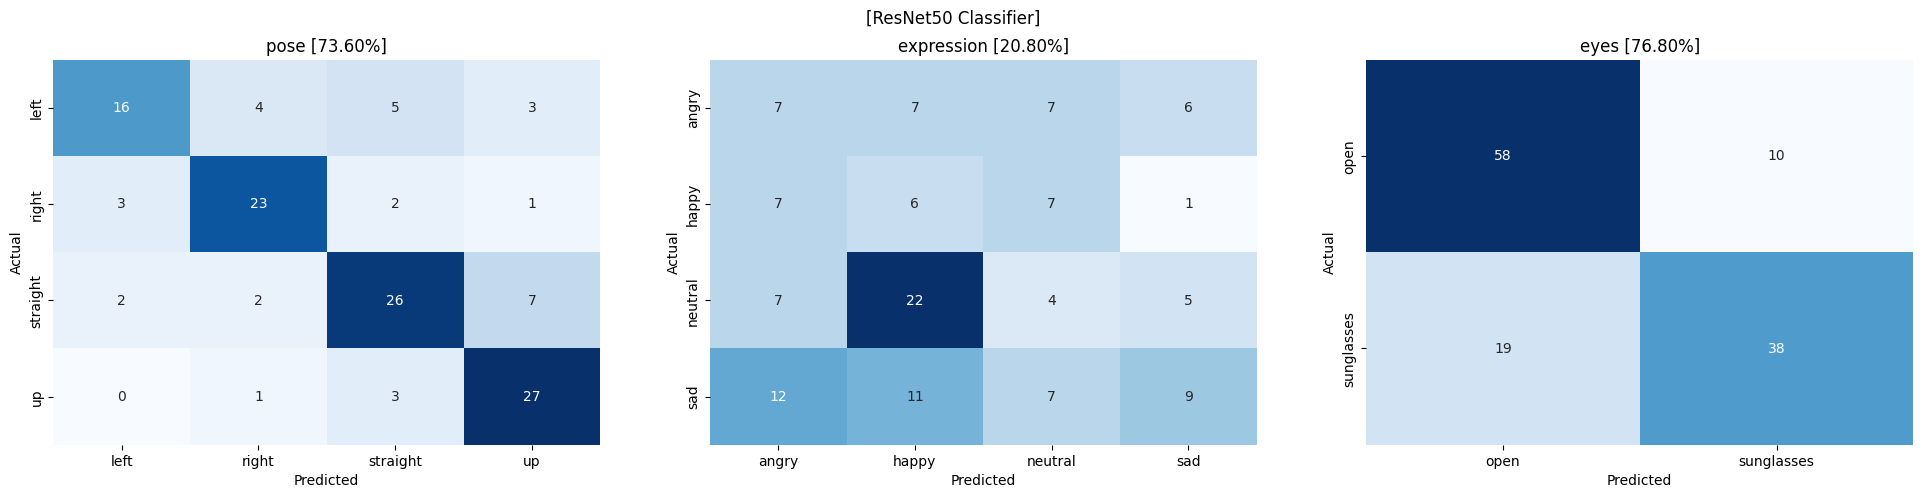

In [39]:
plot_cf_matrix(pred_true_ft, title="[ResNet50 Classifier]")

## CNN Classifier - Clean Lab Suggested Label Original

In [40]:
dataset_cleanlab_org = CMUFaceDatasetCleanLab(data_dir=data_dir, transform=transform, df=df, col='cleanlab_suggested_label_original')
dataset_cleanlab_org_ft = CMUFaceDatasetCleanLab(data_dir=data_dir, transform=transform_ft, df=df, col='cleanlab_suggested_label_original')

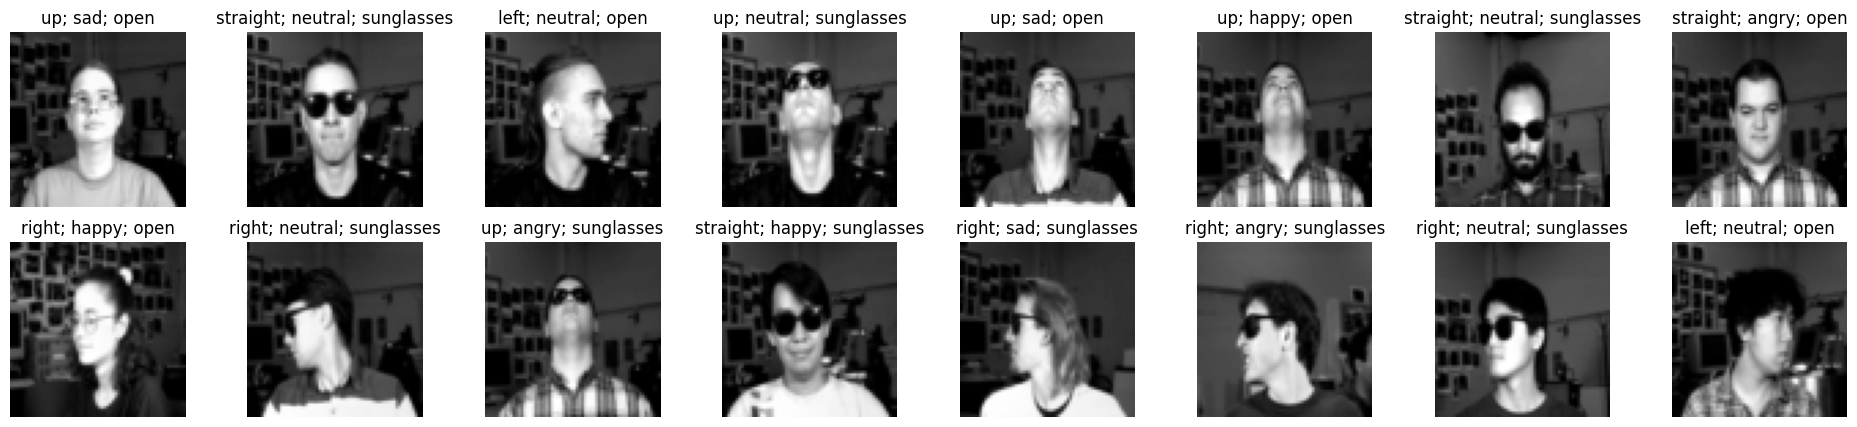

In [41]:
visualize_batch_samples(dataset_cleanlab_org, num_samples=2, batch_size=8)

In [42]:
train_dataset_cleanlab_org, val_dataset_cleanlab_org = random_split(dataset_cleanlab_org, [train_size, val_size])
train_dataset_cleanlab_org_ft, val_dataset_cleanlab_org_ft = random_split(dataset_cleanlab_org_ft, [train_size, val_size])

train_loader_cleanlab_org = DataLoader(train_dataset_cleanlab_org, batch_size=32, shuffle=True)
val_loader_cleanlab_org = DataLoader(val_dataset_cleanlab_org, batch_size=32)

train_loader_cleanlab_org_ft = DataLoader(train_dataset_cleanlab_org_ft, batch_size=32, shuffle=True)
val_loader_cleanlab_org_ft = DataLoader(val_dataset_cleanlab_org_ft, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [43]:
model = MultitaskFaceClassifier(
    num_poses=metadata_info['num_poses'],
    num_expressions=metadata_info['num_expressions'],
    num_eye_states=metadata_info['num_eye_states']
).to(device)

In [44]:
trained_model_cleanlab_org, losses_cleanlab_org = train_model(model, train_loader_cleanlab_org, val_loader_cleanlab_org, metadata_info, num_epochs=num_epochs)

Using device: cuda

Epoch 1/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 117.86it/s]


[train loss] pose: 1.3146; expression: 1.5744; eyes: 0.7174; total: 2.8192
[train acc]  pose: 0.3888; expression: 0.2244; eyes: 0.5070



val: 100%|██████████| 4/4 [00:00<00:00, 363.84it/s]


[val loss] pose: 1.3493; expression: 1.3878; eyes: 0.6838; total: 2.7270
[val acc]  pose: 0.2320; expression: 0.2080; eyes: 0.5600

Epoch 2/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 119.24it/s]


[train loss] pose: 1.0618; expression: 1.5012; eyes: 0.6101; total: 2.4224
[train acc]  pose: 0.6152; expression: 0.2485; eyes: 0.6834



val: 100%|██████████| 4/4 [00:00<00:00, 382.24it/s]


[val loss] pose: 1.0143; expression: 1.3655; eyes: 0.6093; total: 2.3064
[val acc]  pose: 0.7600; expression: 0.3520; eyes: 0.6400

Epoch 3/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 123.85it/s]


[train loss] pose: 0.8724; expression: 1.3604; eyes: 0.5068; total: 2.0594
[train acc]  pose: 0.7214; expression: 0.3407; eyes: 0.7876



val: 100%|██████████| 4/4 [00:00<00:00, 383.48it/s]


[val loss] pose: 0.7364; expression: 1.3323; eyes: 0.4810; total: 1.8835
[val acc]  pose: 0.8800; expression: 0.3760; eyes: 0.8240

Epoch 4/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 124.17it/s]


[train loss] pose: 0.7690; expression: 1.3484; eyes: 0.4709; total: 1.9142
[train acc]  pose: 0.7735; expression: 0.3647; eyes: 0.8257



val: 100%|██████████| 4/4 [00:00<00:00, 389.12it/s]


[val loss] pose: 0.5906; expression: 1.3071; eyes: 0.4004; total: 1.6445
[val acc]  pose: 0.8800; expression: 0.3840; eyes: 0.8480

Epoch 5/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 124.46it/s]


[train loss] pose: 0.6720; expression: 1.3503; eyes: 0.4090; total: 1.7561
[train acc]  pose: 0.8176; expression: 0.3768; eyes: 0.8417



val: 100%|██████████| 4/4 [00:00<00:00, 380.05it/s]


[val loss] pose: 0.4850; expression: 1.2974; eyes: 0.3337; total: 1.4674
[val acc]  pose: 0.9200; expression: 0.4800; eyes: 0.9120

Epoch 6/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 124.38it/s]


[train loss] pose: 0.5629; expression: 1.3184; eyes: 0.3112; total: 1.5334
[train acc]  pose: 0.8597; expression: 0.3667; eyes: 0.9158



val: 100%|██████████| 4/4 [00:00<00:00, 388.85it/s]


[val loss] pose: 0.4132; expression: 1.2940; eyes: 0.2783; total: 1.3385
[val acc]  pose: 0.9280; expression: 0.4320; eyes: 0.9280

Epoch 7/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 124.05it/s]


[train loss] pose: 0.4724; expression: 1.3161; eyes: 0.2847; total: 1.4152
[train acc]  pose: 0.9038; expression: 0.4008; eyes: 0.9299



val: 100%|██████████| 4/4 [00:00<00:00, 364.05it/s]


[val loss] pose: 0.3410; expression: 1.2963; eyes: 0.2401; total: 1.2292
[val acc]  pose: 0.9360; expression: 0.4640; eyes: 0.9600

Epoch 8/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 125.82it/s]


[train loss] pose: 0.4194; expression: 1.2777; eyes: 0.2386; total: 1.2969
[train acc]  pose: 0.9339; expression: 0.4349; eyes: 0.9479



val: 100%|██████████| 4/4 [00:00<00:00, 387.15it/s]


[val loss] pose: 0.3331; expression: 1.2962; eyes: 0.2358; total: 1.2169
[val acc]  pose: 0.9360; expression: 0.4480; eyes: 0.9600

Epoch 9/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 124.35it/s]


[train loss] pose: 0.4222; expression: 1.2942; eyes: 0.2584; total: 1.3277
[train acc]  pose: 0.9198; expression: 0.3928; eyes: 0.9319



val: 100%|██████████| 4/4 [00:00<00:00, 374.68it/s]


[val loss] pose: 0.3285; expression: 1.2929; eyes: 0.2261; total: 1.2010
[val acc]  pose: 0.9360; expression: 0.4560; eyes: 0.9840

Epoch 10/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 125.21it/s]


[train loss] pose: 0.4021; expression: 1.3022; eyes: 0.2477; total: 1.3009
[train acc]  pose: 0.9459; expression: 0.4068; eyes: 0.9279



val: 100%|██████████| 4/4 [00:00<00:00, 377.70it/s]


[val loss] pose: 0.3275; expression: 1.2987; eyes: 0.2259; total: 1.2028
[val acc]  pose: 0.9360; expression: 0.4720; eyes: 0.9680

Epoch 11/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 123.88it/s]


[train loss] pose: 0.4000; expression: 1.2920; eyes: 0.2429; total: 1.2889
[train acc]  pose: 0.9459; expression: 0.4228; eyes: 0.9279



val: 100%|██████████| 4/4 [00:00<00:00, 376.27it/s]


[val loss] pose: 0.3220; expression: 1.2943; eyes: 0.2219; total: 1.1910
[val acc]  pose: 0.9360; expression: 0.4480; eyes: 0.9680

Epoch 12/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 123.81it/s]


[train loss] pose: 0.3955; expression: 1.3016; eyes: 0.2294; total: 1.2757
[train acc]  pose: 0.9299; expression: 0.4188; eyes: 0.9479



val: 100%|██████████| 4/4 [00:00<00:00, 381.82it/s]


[val loss] pose: 0.3225; expression: 1.2941; eyes: 0.2184; total: 1.1880
[val acc]  pose: 0.9360; expression: 0.4480; eyes: 0.9680

Epoch 13/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 123.51it/s]


[train loss] pose: 0.3952; expression: 1.2755; eyes: 0.2247; total: 1.2577
[train acc]  pose: 0.9299; expression: 0.4269; eyes: 0.9479



val: 100%|██████████| 4/4 [00:00<00:00, 365.27it/s]


[val loss] pose: 0.3151; expression: 1.2923; eyes: 0.2146; total: 1.1759
[val acc]  pose: 0.9360; expression: 0.4560; eyes: 0.9520

Epoch 14/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 123.77it/s]


[train loss] pose: 0.3801; expression: 1.3029; eyes: 0.2246; total: 1.2562
[train acc]  pose: 0.9419; expression: 0.4068; eyes: 0.9379



val: 100%|██████████| 4/4 [00:00<00:00, 372.04it/s]


[val loss] pose: 0.2954; expression: 1.2954; eyes: 0.1995; total: 1.1426
[val acc]  pose: 0.9360; expression: 0.4480; eyes: 0.9840

Epoch 15/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 124.68it/s]


[train loss] pose: 0.3872; expression: 1.2916; eyes: 0.2162; total: 1.2492
[train acc]  pose: 0.9299; expression: 0.4289; eyes: 0.9499



val: 100%|██████████| 4/4 [00:00<00:00, 351.78it/s]


[val loss] pose: 0.2983; expression: 1.2935; eyes: 0.2034; total: 1.1484
[val acc]  pose: 0.9360; expression: 0.4640; eyes: 0.9840

Epoch 16/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 121.88it/s]


[train loss] pose: 0.3630; expression: 1.3028; eyes: 0.2076; total: 1.2220
[train acc]  pose: 0.9439; expression: 0.4148; eyes: 0.9519



val: 100%|██████████| 4/4 [00:00<00:00, 312.91it/s]


[val loss] pose: 0.2992; expression: 1.2959; eyes: 0.2058; total: 1.1530
[val acc]  pose: 0.9360; expression: 0.4480; eyes: 0.9840

Epoch 17/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 124.20it/s]


[train loss] pose: 0.3616; expression: 1.3070; eyes: 0.2010; total: 1.2160
[train acc]  pose: 0.9519; expression: 0.3948; eyes: 0.9639



val: 100%|██████████| 4/4 [00:00<00:00, 377.99it/s]


[val loss] pose: 0.2953; expression: 1.2926; eyes: 0.2056; total: 1.1472
[val acc]  pose: 0.9440; expression: 0.4400; eyes: 0.9840

Epoch 18/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 123.84it/s]


[train loss] pose: 0.3844; expression: 1.2911; eyes: 0.2012; total: 1.2312
[train acc]  pose: 0.9238; expression: 0.4208; eyes: 0.9619



val: 100%|██████████| 4/4 [00:00<00:00, 373.13it/s]


[val loss] pose: 0.3001; expression: 1.2911; eyes: 0.2035; total: 1.1491
[val acc]  pose: 0.9360; expression: 0.4640; eyes: 0.9840

Epoch 19/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 125.19it/s]


[train loss] pose: 0.3666; expression: 1.2820; eyes: 0.2063; total: 1.2139
[train acc]  pose: 0.9519; expression: 0.4148; eyes: 0.9459



val: 100%|██████████| 4/4 [00:00<00:00, 373.20it/s]


[val loss] pose: 0.2941; expression: 1.2901; eyes: 0.2013; total: 1.1404
[val acc]  pose: 0.9360; expression: 0.4560; eyes: 0.9840

Epoch 20/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 124.36it/s]


[train loss] pose: 0.3657; expression: 1.3030; eyes: 0.2030; total: 1.2203
[train acc]  pose: 0.9379; expression: 0.4108; eyes: 0.9639



val: 100%|██████████| 4/4 [00:00<00:00, 378.79it/s]

[val loss] pose: 0.2915; expression: 1.2912; eyes: 0.2032; total: 1.1403
[val acc]  pose: 0.9360; expression: 0.4400; eyes: 0.9840

Training complete in 0m 3s


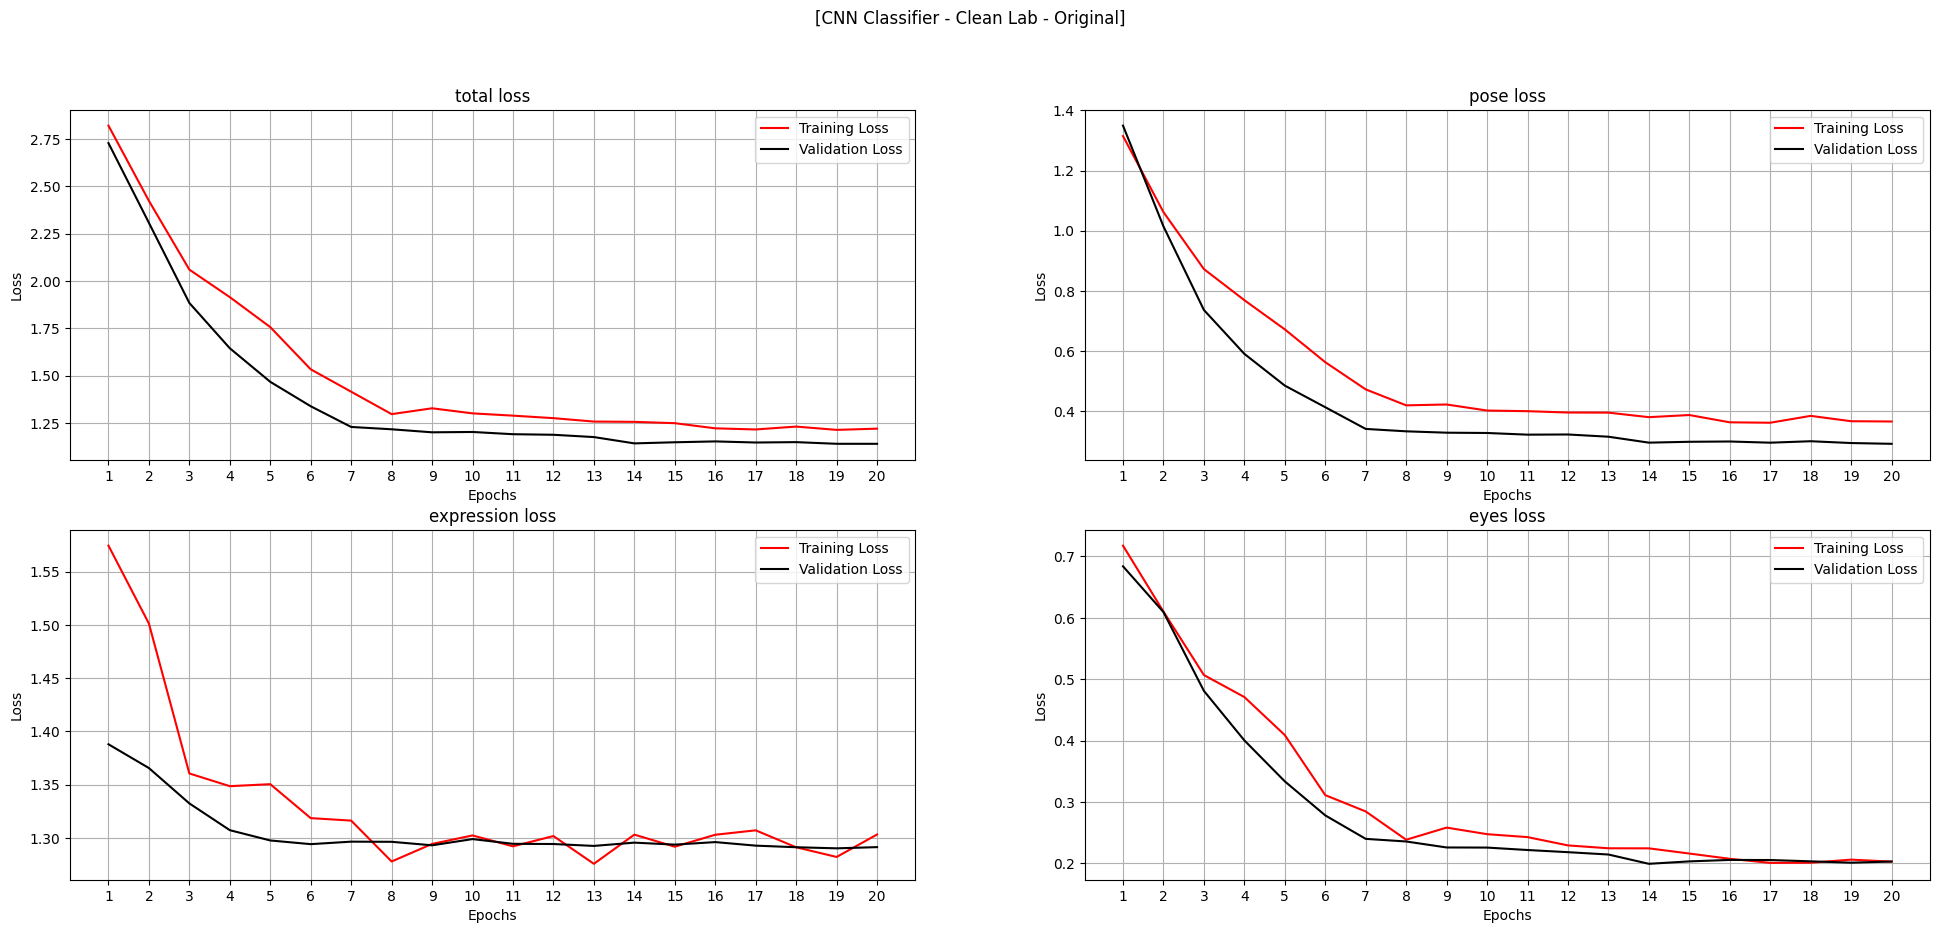

In [45]:
plot_losses(losses_cleanlab_org, title="[CNN Classifier - Clean Lab - Original]")

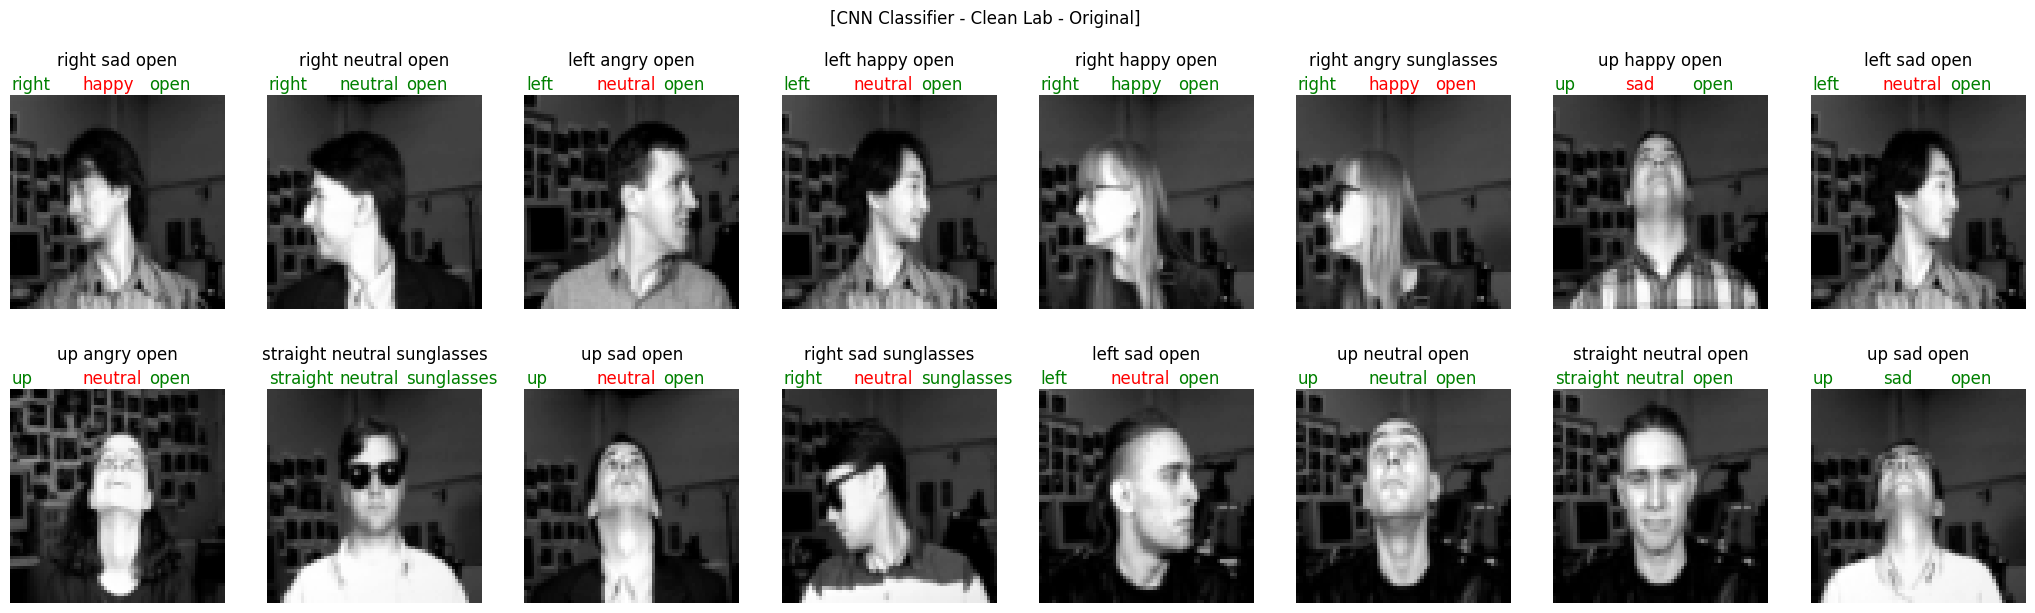

In [46]:
pred_true_cleanlab_org = visualize_predictions(trained_model_cleanlab_org, val_loader_cleanlab_org, metadata_info,
                                               num_images=16, title="[CNN Classifier - Clean Lab - Original]")

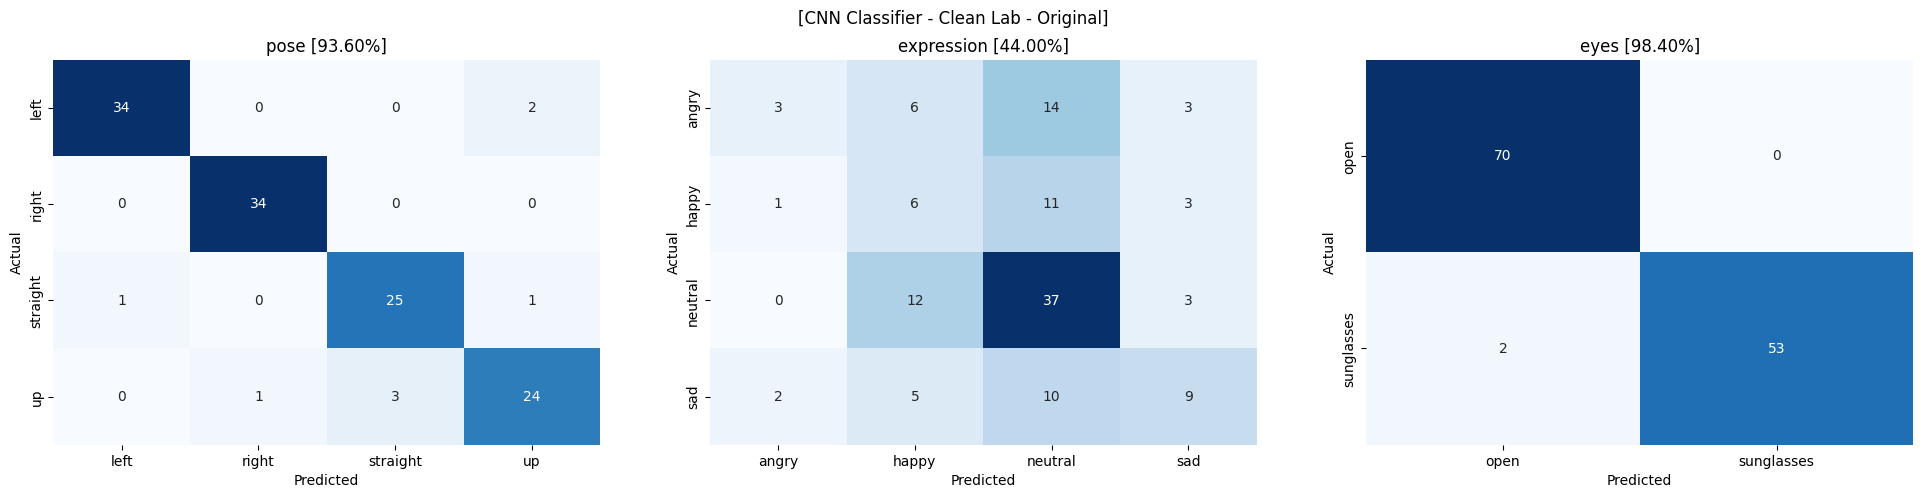

In [47]:
plot_cf_matrix(pred_true_cleanlab_org, title="[CNN Classifier - Clean Lab - Original]")

## ResNet50 Classifier - Clean Lab Suggested Label Original

In [48]:
model_ft = MultiTaskResNet50(
    metadata_info['num_poses'],
    metadata_info['num_expressions'],
    metadata_info['num_eye_states']
).to(device)

In [49]:
trained_model_cleanlab_org_ft, losses_cleanlab_org_ft = train_model(model_ft, train_loader_cleanlab_org_ft,
                                                        val_loader_cleanlab_org_ft, metadata_info, num_epochs=num_epochs, pretrained=True)

Using device: cuda

Epoch 1/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 39.66it/s]


[train loss] pose: 1.4740; expression: 1.5512; eyes: 0.7569; total: 3.0065
[train acc]  pose: 0.2425; expression: 0.2445; eyes: 0.5210



val: 100%|██████████| 4/4 [00:00<00:00, 88.67it/s]


[val loss] pose: 1.3720; expression: 1.3713; eyes: 0.6717; total: 2.7293
[val acc]  pose: 0.2880; expression: 0.3360; eyes: 0.6080

Epoch 2/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 40.98it/s]


[train loss] pose: 1.3437; expression: 1.4577; eyes: 0.7183; total: 2.7908
[train acc]  pose: 0.3307; expression: 0.2705; eyes: 0.5150



val: 100%|██████████| 4/4 [00:00<00:00, 88.38it/s]


[val loss] pose: 1.3777; expression: 1.3279; eyes: 0.6650; total: 2.7066
[val acc]  pose: 0.2880; expression: 0.3760; eyes: 0.5840

Epoch 3/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.25it/s]


[train loss] pose: 1.2682; expression: 1.4079; eyes: 0.6490; total: 2.6212
[train acc]  pose: 0.4008; expression: 0.3246; eyes: 0.6413



val: 100%|██████████| 4/4 [00:00<00:00, 89.05it/s]


[val loss] pose: 1.3415; expression: 1.3154; eyes: 0.6635; total: 2.6628
[val acc]  pose: 0.3280; expression: 0.4080; eyes: 0.6240

Epoch 4/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.14it/s]


[train loss] pose: 1.1648; expression: 1.3284; eyes: 0.6319; total: 2.4608
[train acc]  pose: 0.5271; expression: 0.4028; eyes: 0.6433



val: 100%|██████████| 4/4 [00:00<00:00, 86.87it/s]


[val loss] pose: 1.2871; expression: 1.3419; eyes: 0.6426; total: 2.6006
[val acc]  pose: 0.4400; expression: 0.4160; eyes: 0.6160

Epoch 5/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 40.27it/s]


[train loss] pose: 1.0435; expression: 1.3314; eyes: 0.5464; total: 2.2556
[train acc]  pose: 0.6072; expression: 0.3968; eyes: 0.7475



val: 100%|██████████| 4/4 [00:00<00:00, 88.34it/s]


[val loss] pose: 1.1345; expression: 1.3057; eyes: 0.5989; total: 2.3863
[val acc]  pose: 0.5600; expression: 0.4400; eyes: 0.6960

Epoch 6/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.23it/s]


[train loss] pose: 0.9863; expression: 1.3039; eyes: 0.5238; total: 2.1620
[train acc]  pose: 0.6032; expression: 0.4088; eyes: 0.7455



val: 100%|██████████| 4/4 [00:00<00:00, 89.11it/s]


[val loss] pose: 1.0101; expression: 1.2874; eyes: 0.5505; total: 2.2043
[val acc]  pose: 0.6800; expression: 0.4400; eyes: 0.7200

Epoch 7/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.20it/s]


[train loss] pose: 0.9064; expression: 1.3213; eyes: 0.4807; total: 2.0478
[train acc]  pose: 0.6874; expression: 0.4108; eyes: 0.7836



val: 100%|██████████| 4/4 [00:00<00:00, 89.10it/s]


[val loss] pose: 0.9271; expression: 1.2927; eyes: 0.5189; total: 2.0923
[val acc]  pose: 0.7840; expression: 0.4160; eyes: 0.7280

Epoch 8/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.27it/s]


[train loss] pose: 0.8421; expression: 1.3110; eyes: 0.4569; total: 1.9545
[train acc]  pose: 0.7054; expression: 0.4048; eyes: 0.8136



val: 100%|██████████| 4/4 [00:00<00:00, 89.67it/s]


[val loss] pose: 0.9262; expression: 1.2923; eyes: 0.5226; total: 2.0950
[val acc]  pose: 0.7680; expression: 0.4320; eyes: 0.6960

Epoch 9/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.14it/s]


[train loss] pose: 0.8199; expression: 1.2632; eyes: 0.4574; total: 1.9089
[train acc]  pose: 0.7475; expression: 0.4289; eyes: 0.7936



val: 100%|██████████| 4/4 [00:00<00:00, 89.03it/s]


[val loss] pose: 0.9212; expression: 1.2794; eyes: 0.5220; total: 2.0829
[val acc]  pose: 0.7840; expression: 0.4320; eyes: 0.7040

Epoch 10/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 40.71it/s]


[train loss] pose: 0.8162; expression: 1.2615; eyes: 0.4483; total: 1.8953
[train acc]  pose: 0.7415; expression: 0.4449; eyes: 0.8236



val: 100%|██████████| 4/4 [00:00<00:00, 88.20it/s]


[val loss] pose: 0.9182; expression: 1.2819; eyes: 0.5134; total: 2.0726
[val acc]  pose: 0.7600; expression: 0.4400; eyes: 0.7200

Epoch 11/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.17it/s]


[train loss] pose: 0.7973; expression: 1.2506; eyes: 0.4335; total: 1.8562
[train acc]  pose: 0.7555; expression: 0.4409; eyes: 0.8116



val: 100%|██████████| 4/4 [00:00<00:00, 88.61it/s]


[val loss] pose: 0.9093; expression: 1.2837; eyes: 0.5170; total: 2.0682
[val acc]  pose: 0.7680; expression: 0.4400; eyes: 0.7040

Epoch 12/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.32it/s]


[train loss] pose: 0.8246; expression: 1.2576; eyes: 0.4526; total: 1.9059
[train acc]  pose: 0.7295; expression: 0.4208; eyes: 0.8096



val: 100%|██████████| 4/4 [00:00<00:00, 89.29it/s]


[val loss] pose: 0.8988; expression: 1.2865; eyes: 0.5179; total: 2.0599
[val acc]  pose: 0.7920; expression: 0.4560; eyes: 0.7280

Epoch 13/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.36it/s]


[train loss] pose: 0.7950; expression: 1.3018; eyes: 0.4579; total: 1.9038
[train acc]  pose: 0.7455; expression: 0.4168; eyes: 0.8056



val: 100%|██████████| 4/4 [00:00<00:00, 88.56it/s]


[val loss] pose: 0.9038; expression: 1.2821; eyes: 0.5094; total: 2.0542
[val acc]  pose: 0.7840; expression: 0.4480; eyes: 0.7040

Epoch 14/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.22it/s]


[train loss] pose: 0.7849; expression: 1.2892; eyes: 0.4196; total: 1.8491
[train acc]  pose: 0.7435; expression: 0.4208; eyes: 0.8357



val: 100%|██████████| 4/4 [00:00<00:00, 88.79it/s]


[val loss] pose: 0.8784; expression: 1.2745; eyes: 0.5112; total: 2.0269
[val acc]  pose: 0.8080; expression: 0.4560; eyes: 0.7280

Epoch 15/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.25it/s]


[train loss] pose: 0.7876; expression: 1.2940; eyes: 0.4194; total: 1.8540
[train acc]  pose: 0.7555; expression: 0.3948; eyes: 0.8397



val: 100%|██████████| 4/4 [00:00<00:00, 88.78it/s]


[val loss] pose: 0.8771; expression: 1.2849; eyes: 0.5044; total: 2.0239
[val acc]  pose: 0.8000; expression: 0.4320; eyes: 0.7120

Epoch 16/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.19it/s]


[train loss] pose: 0.7668; expression: 1.2405; eyes: 0.4266; total: 1.8136
[train acc]  pose: 0.7896; expression: 0.4168; eyes: 0.8136



val: 100%|██████████| 4/4 [00:00<00:00, 88.54it/s]


[val loss] pose: 0.8852; expression: 1.2793; eyes: 0.5046; total: 2.0294
[val acc]  pose: 0.8080; expression: 0.4400; eyes: 0.7200

Epoch 17/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.04it/s]


[train loss] pose: 0.7547; expression: 1.2522; eyes: 0.4313; total: 1.8120
[train acc]  pose: 0.7675; expression: 0.4248; eyes: 0.8116



val: 100%|██████████| 4/4 [00:00<00:00, 87.92it/s]


[val loss] pose: 0.8784; expression: 1.2792; eyes: 0.5015; total: 2.0195
[val acc]  pose: 0.8000; expression: 0.4560; eyes: 0.7360

Epoch 18/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 40.73it/s]


[train loss] pose: 0.7869; expression: 1.2177; eyes: 0.4178; total: 1.8136
[train acc]  pose: 0.7695; expression: 0.4449; eyes: 0.8297



val: 100%|██████████| 4/4 [00:00<00:00, 87.80it/s]


[val loss] pose: 0.8893; expression: 1.2830; eyes: 0.5095; total: 2.0403
[val acc]  pose: 0.8000; expression: 0.4480; eyes: 0.7200

Epoch 19/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.21it/s]


[train loss] pose: 0.7723; expression: 1.2853; eyes: 0.4481; total: 1.8630
[train acc]  pose: 0.7615; expression: 0.4008; eyes: 0.8076



val: 100%|██████████| 4/4 [00:00<00:00, 89.18it/s]


[val loss] pose: 0.8853; expression: 1.2844; eyes: 0.5042; total: 2.0317
[val acc]  pose: 0.7840; expression: 0.4240; eyes: 0.7200

Epoch 20/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.03it/s]


[train loss] pose: 0.7918; expression: 1.2603; eyes: 0.4438; total: 1.8657
[train acc]  pose: 0.7595; expression: 0.4449; eyes: 0.8136



val: 100%|██████████| 4/4 [00:00<00:00, 88.96it/s]

[val loss] pose: 0.8901; expression: 1.2803; eyes: 0.4978; total: 2.0281
[val acc]  pose: 0.7920; expression: 0.4320; eyes: 0.7120

Training complete in 0m 9s


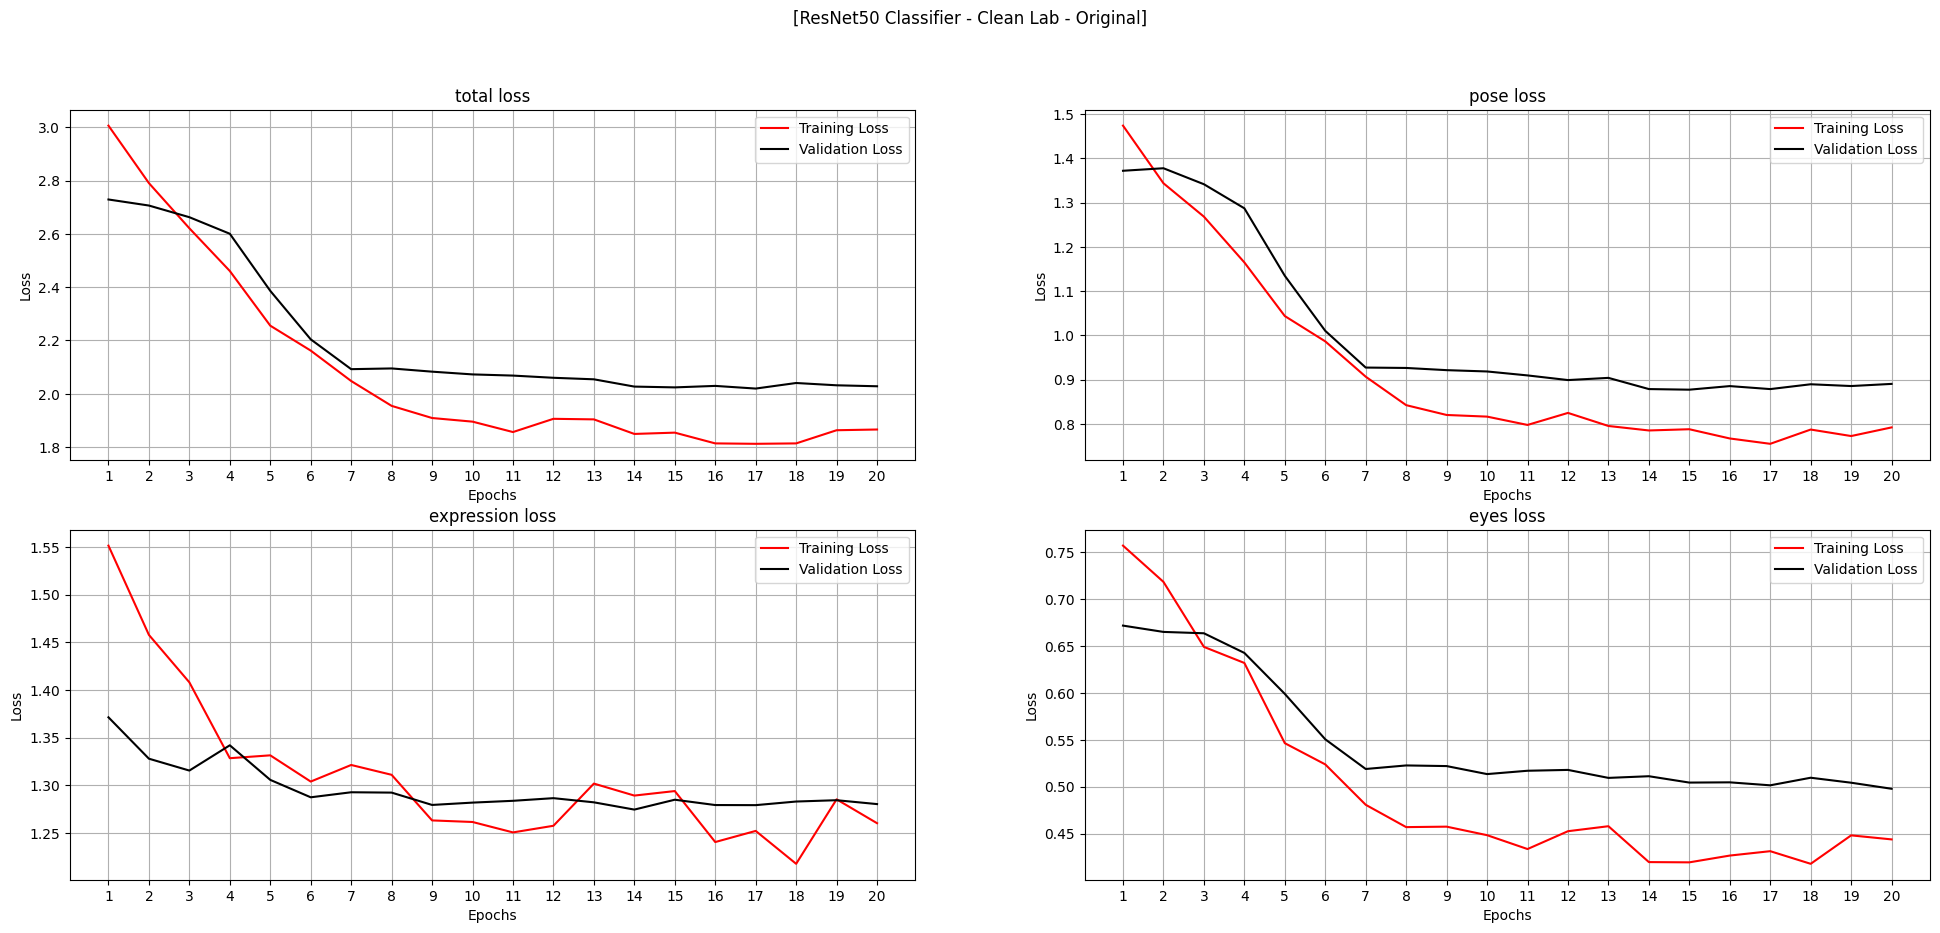

In [50]:
plot_losses(losses_cleanlab_org_ft, title="[ResNet50 Classifier - Clean Lab - Original]")

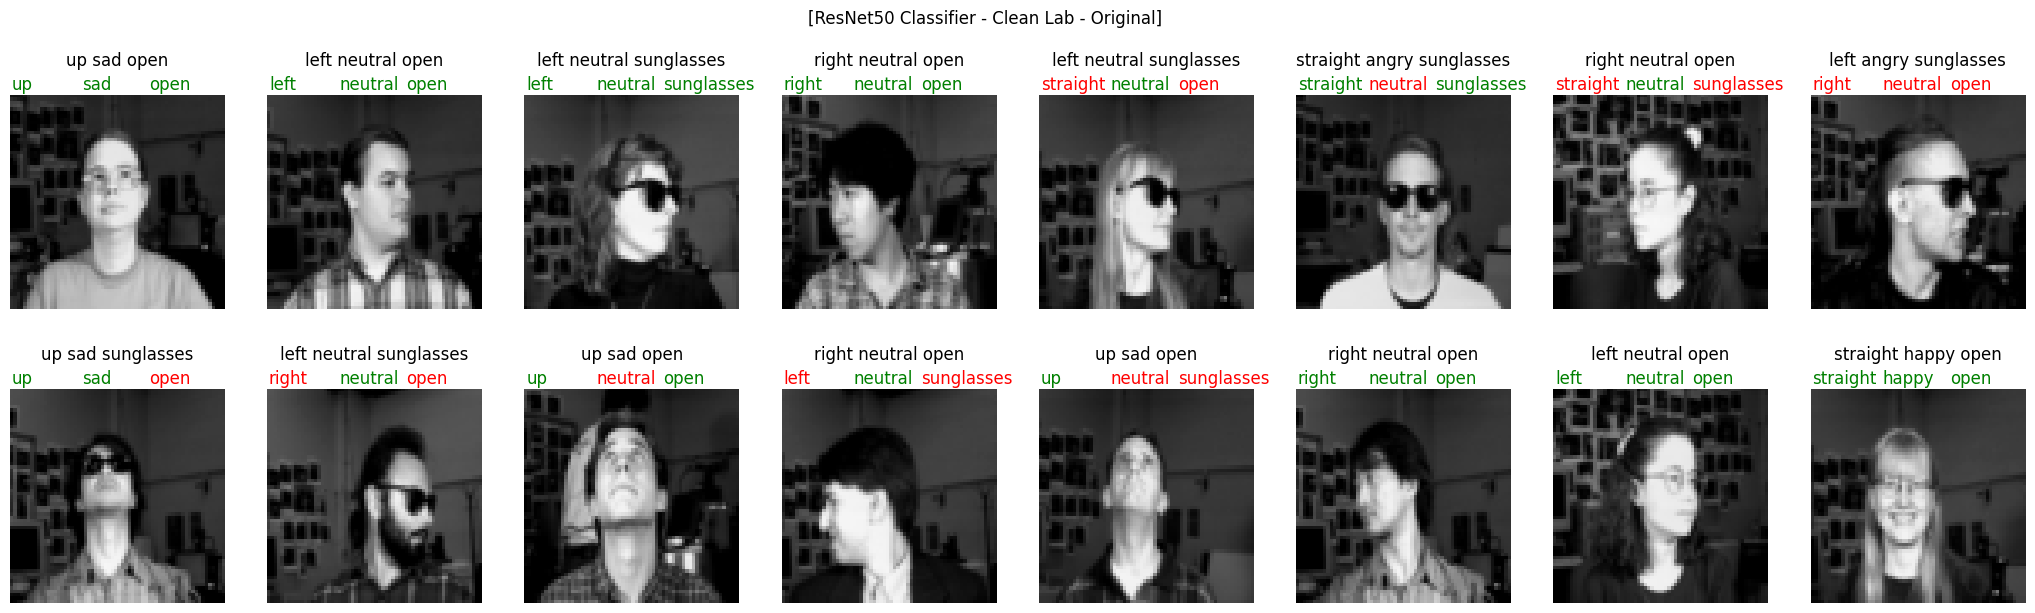

In [51]:
pred_true_cleanlab_org_ft = visualize_predictions(trained_model_cleanlab_org_ft, val_loader_cleanlab_org_ft,
                                                  metadata_info, num_images=16, pretrained=True, title="[ResNet50 Classifier - Clean Lab - Original]")

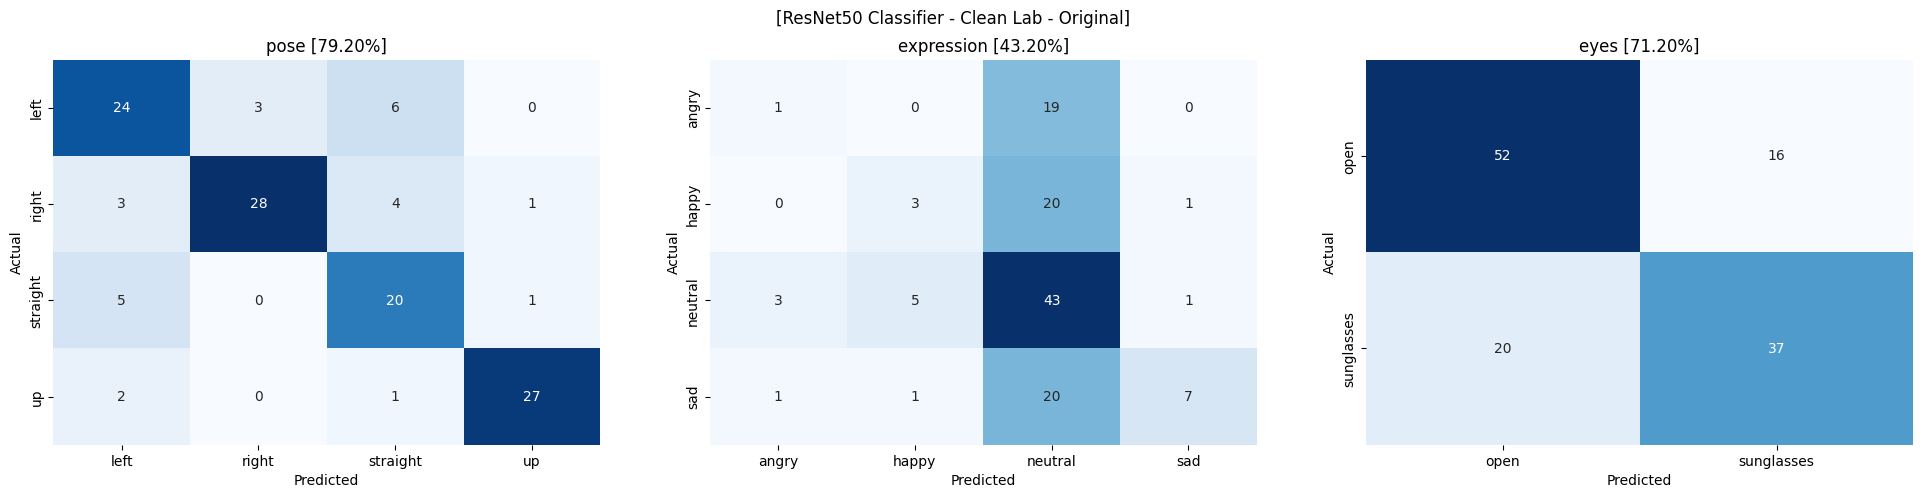

In [52]:
plot_cf_matrix(pred_true_cleanlab_org_ft, title="[ResNet50 Classifier - Clean Lab - Original]")

## CNN Classifier - Clean Lab Suggested Label Pred

In [53]:
dataset_cleanlab_pred = CMUFaceDatasetCleanLab(data_dir=data_dir, transform=transform, df=df, col='cleanlab_suggested_label_pred')
dataset_cleanlab_pred_ft = CMUFaceDatasetCleanLab(data_dir=data_dir, transform=transform_ft, df=df, col='cleanlab_suggested_label_pred')

In [54]:
train_dataset_cleanlab_pred, val_dataset_cleanlab_pred = random_split(dataset_cleanlab_pred, [train_size, val_size])
train_dataset_cleanlab_pred_ft, val_dataset_cleanlab_pred_ft = random_split(dataset_cleanlab_pred_ft, [train_size, val_size])

train_loader_cleanlab_pred = DataLoader(train_dataset_cleanlab_pred, batch_size=32, shuffle=True)
val_loader_cleanlab_pred = DataLoader(val_dataset_cleanlab_pred, batch_size=32)

train_loader_cleanlab_pred_ft = DataLoader(train_dataset_cleanlab_pred_ft, batch_size=32, shuffle=True)
val_loader_cleanlab_pred_ft = DataLoader(val_dataset_cleanlab_pred_ft, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [55]:
model = MultitaskFaceClassifier(
    num_poses=metadata_info['num_poses'],
    num_expressions=metadata_info['num_expressions'],
    num_eye_states=metadata_info['num_eye_states']
).to(device)

In [56]:
trained_model_cleanlab_pred, losses_cleanlab_pred = train_model(model, train_loader_cleanlab_pred, val_loader_cleanlab_pred, metadata_info, num_epochs=num_epochs)

Using device: cuda

Epoch 1/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 118.93it/s]


[train loss] pose: 1.3545; expression: 1.5277; eyes: 0.6995; total: 2.8179
[train acc]  pose: 0.3287; expression: 0.2285; eyes: 0.5471



val: 100%|██████████| 4/4 [00:00<00:00, 373.95it/s]


[val loss] pose: 1.3599; expression: 1.3984; eyes: 0.6879; total: 2.7470
[val acc]  pose: 0.5120; expression: 0.2640; eyes: 0.5360

Epoch 2/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 124.03it/s]


[train loss] pose: 1.1021; expression: 1.4250; eyes: 0.6080; total: 2.4227
[train acc]  pose: 0.5912; expression: 0.3046; eyes: 0.6713



val: 100%|██████████| 4/4 [00:00<00:00, 378.21it/s]


[val loss] pose: 1.1121; expression: 1.3750; eyes: 0.6260; total: 2.4255
[val acc]  pose: 0.7920; expression: 0.2560; eyes: 0.8240

Epoch 3/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 124.34it/s]


[train loss] pose: 0.9319; expression: 1.3320; eyes: 0.5284; total: 2.1263
[train acc]  pose: 0.7415; expression: 0.3888; eyes: 0.7756



val: 100%|██████████| 4/4 [00:00<00:00, 372.36it/s]


[val loss] pose: 0.8380; expression: 1.3272; eyes: 0.4918; total: 1.9935
[val acc]  pose: 0.8400; expression: 0.3920; eyes: 0.9040

Epoch 4/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 123.55it/s]


[train loss] pose: 0.7950; expression: 1.3261; eyes: 0.4670; total: 1.9250
[train acc]  pose: 0.7715; expression: 0.4008; eyes: 0.8176



val: 100%|██████████| 4/4 [00:00<00:00, 369.24it/s]


[val loss] pose: 0.6504; expression: 1.2851; eyes: 0.4041; total: 1.6970
[val acc]  pose: 0.9040; expression: 0.4320; eyes: 0.9600

Epoch 5/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 124.80it/s]


[train loss] pose: 0.6610; expression: 1.2898; eyes: 0.3895; total: 1.6954
[train acc]  pose: 0.8417; expression: 0.4188; eyes: 0.8858



val: 100%|██████████| 4/4 [00:00<00:00, 378.36it/s]


[val loss] pose: 0.5636; expression: 1.2758; eyes: 0.3032; total: 1.5047
[val acc]  pose: 0.9120; expression: 0.4480; eyes: 0.9680

Epoch 6/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 124.01it/s]


[train loss] pose: 0.5772; expression: 1.2823; eyes: 0.3151; total: 1.5335
[train acc]  pose: 0.8637; expression: 0.4208; eyes: 0.9138



val: 100%|██████████| 4/4 [00:00<00:00, 363.24it/s]


[val loss] pose: 0.4542; expression: 1.2711; eyes: 0.2376; total: 1.3273
[val acc]  pose: 0.9280; expression: 0.4080; eyes: 0.9760

Epoch 7/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 125.32it/s]


[train loss] pose: 0.4769; expression: 1.2950; eyes: 0.2708; total: 1.3952
[train acc]  pose: 0.9118; expression: 0.4168; eyes: 0.9158



val: 100%|██████████| 4/4 [00:00<00:00, 377.52it/s]


[val loss] pose: 0.3787; expression: 1.2591; eyes: 0.2051; total: 1.2133
[val acc]  pose: 0.9360; expression: 0.4240; eyes: 0.9760

Epoch 8/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 123.34it/s]


[train loss] pose: 0.4224; expression: 1.2537; eyes: 0.2558; total: 1.3050
[train acc]  pose: 0.9238; expression: 0.4248; eyes: 0.9379



val: 100%|██████████| 4/4 [00:00<00:00, 384.83it/s]


[val loss] pose: 0.3850; expression: 1.2619; eyes: 0.1995; total: 1.2154
[val acc]  pose: 0.9360; expression: 0.4320; eyes: 0.9760

Epoch 9/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 123.78it/s]


[train loss] pose: 0.4369; expression: 1.2646; eyes: 0.2397; total: 1.3089
[train acc]  pose: 0.9038; expression: 0.4369; eyes: 0.9419



val: 100%|██████████| 4/4 [00:00<00:00, 383.73it/s]


[val loss] pose: 0.3688; expression: 1.2563; eyes: 0.1990; total: 1.1960
[val acc]  pose: 0.9440; expression: 0.4400; eyes: 0.9760

Epoch 10/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 123.27it/s]


[train loss] pose: 0.4025; expression: 1.2372; eyes: 0.2411; total: 1.2622
[train acc]  pose: 0.9439; expression: 0.4549; eyes: 0.9519



val: 100%|██████████| 4/4 [00:00<00:00, 393.76it/s]


[val loss] pose: 0.3650; expression: 1.2604; eyes: 0.1938; total: 1.1890
[val acc]  pose: 0.9520; expression: 0.4400; eyes: 0.9840

Epoch 11/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 122.84it/s]


[train loss] pose: 0.4103; expression: 1.2586; eyes: 0.2356; total: 1.2753
[train acc]  pose: 0.9218; expression: 0.4329; eyes: 0.9519



val: 100%|██████████| 4/4 [00:00<00:00, 387.89it/s]


[val loss] pose: 0.3635; expression: 1.2579; eyes: 0.1838; total: 1.1763
[val acc]  pose: 0.9440; expression: 0.4400; eyes: 0.9840

Epoch 12/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 124.34it/s]


[train loss] pose: 0.3961; expression: 1.2760; eyes: 0.2285; total: 1.2626
[train acc]  pose: 0.9178; expression: 0.4208; eyes: 0.9459



val: 100%|██████████| 4/4 [00:00<00:00, 379.51it/s]


[val loss] pose: 0.3580; expression: 1.2542; eyes: 0.1832; total: 1.1682
[val acc]  pose: 0.9440; expression: 0.4320; eyes: 0.9760

Epoch 13/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 122.89it/s]


[train loss] pose: 0.4250; expression: 1.2387; eyes: 0.2344; total: 1.2787
[train acc]  pose: 0.9158; expression: 0.4248; eyes: 0.9459



val: 100%|██████████| 4/4 [00:00<00:00, 370.81it/s]


[val loss] pose: 0.3562; expression: 1.2574; eyes: 0.1774; total: 1.1623
[val acc]  pose: 0.9440; expression: 0.4160; eyes: 0.9840

Epoch 14/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 123.51it/s]


[train loss] pose: 0.3652; expression: 1.2863; eyes: 0.2407; total: 1.2491
[train acc]  pose: 0.9619; expression: 0.4188; eyes: 0.9339



val: 100%|██████████| 4/4 [00:00<00:00, 375.37it/s]


[val loss] pose: 0.3431; expression: 1.2568; eyes: 0.1687; total: 1.1401
[val acc]  pose: 0.9520; expression: 0.4240; eyes: 0.9840

Epoch 15/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 124.46it/s]


[train loss] pose: 0.3937; expression: 1.2167; eyes: 0.2164; total: 1.2184
[train acc]  pose: 0.9279; expression: 0.4389; eyes: 0.9399



val: 100%|██████████| 4/4 [00:00<00:00, 385.98it/s]


[val loss] pose: 0.3437; expression: 1.2548; eyes: 0.1733; total: 1.1444
[val acc]  pose: 0.9440; expression: 0.4400; eyes: 0.9840

Epoch 16/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 122.55it/s]


[train loss] pose: 0.4001; expression: 1.2698; eyes: 0.2060; total: 1.2410
[train acc]  pose: 0.9419; expression: 0.4228; eyes: 0.9539



val: 100%|██████████| 4/4 [00:00<00:00, 399.74it/s]


[val loss] pose: 0.3389; expression: 1.2554; eyes: 0.1766; total: 1.1433
[val acc]  pose: 0.9520; expression: 0.4320; eyes: 0.9840

Epoch 17/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 124.11it/s]


[train loss] pose: 0.4081; expression: 1.2471; eyes: 0.2390; total: 1.2707
[train acc]  pose: 0.9178; expression: 0.4309; eyes: 0.9399



val: 100%|██████████| 4/4 [00:00<00:00, 379.72it/s]


[val loss] pose: 0.3383; expression: 1.2556; eyes: 0.1709; total: 1.1369
[val acc]  pose: 0.9520; expression: 0.4240; eyes: 0.9840

Epoch 18/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 123.87it/s]


[train loss] pose: 0.3557; expression: 1.2488; eyes: 0.2278; total: 1.2079
[train acc]  pose: 0.9459; expression: 0.4589; eyes: 0.9519



val: 100%|██████████| 4/4 [00:00<00:00, 386.90it/s]


[val loss] pose: 0.3458; expression: 1.2557; eyes: 0.1721; total: 1.1457
[val acc]  pose: 0.9520; expression: 0.4560; eyes: 0.9840

Epoch 19/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 123.31it/s]


[train loss] pose: 0.3827; expression: 1.2549; eyes: 0.2099; total: 1.2200
[train acc]  pose: 0.9419; expression: 0.4148; eyes: 0.9579



val: 100%|██████████| 4/4 [00:00<00:00, 387.89it/s]


[val loss] pose: 0.3450; expression: 1.2552; eyes: 0.1700; total: 1.1427
[val acc]  pose: 0.9520; expression: 0.4400; eyes: 0.9840

Epoch 20/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 125.89it/s]


[train loss] pose: 0.3812; expression: 1.2388; eyes: 0.2268; total: 1.2274
[train acc]  pose: 0.9339; expression: 0.4549; eyes: 0.9419



val: 100%|██████████| 4/4 [00:00<00:00, 383.62it/s]

[val loss] pose: 0.3471; expression: 1.2547; eyes: 0.1680; total: 1.1424
[val acc]  pose: 0.9440; expression: 0.4480; eyes: 0.9760

Training complete in 0m 3s


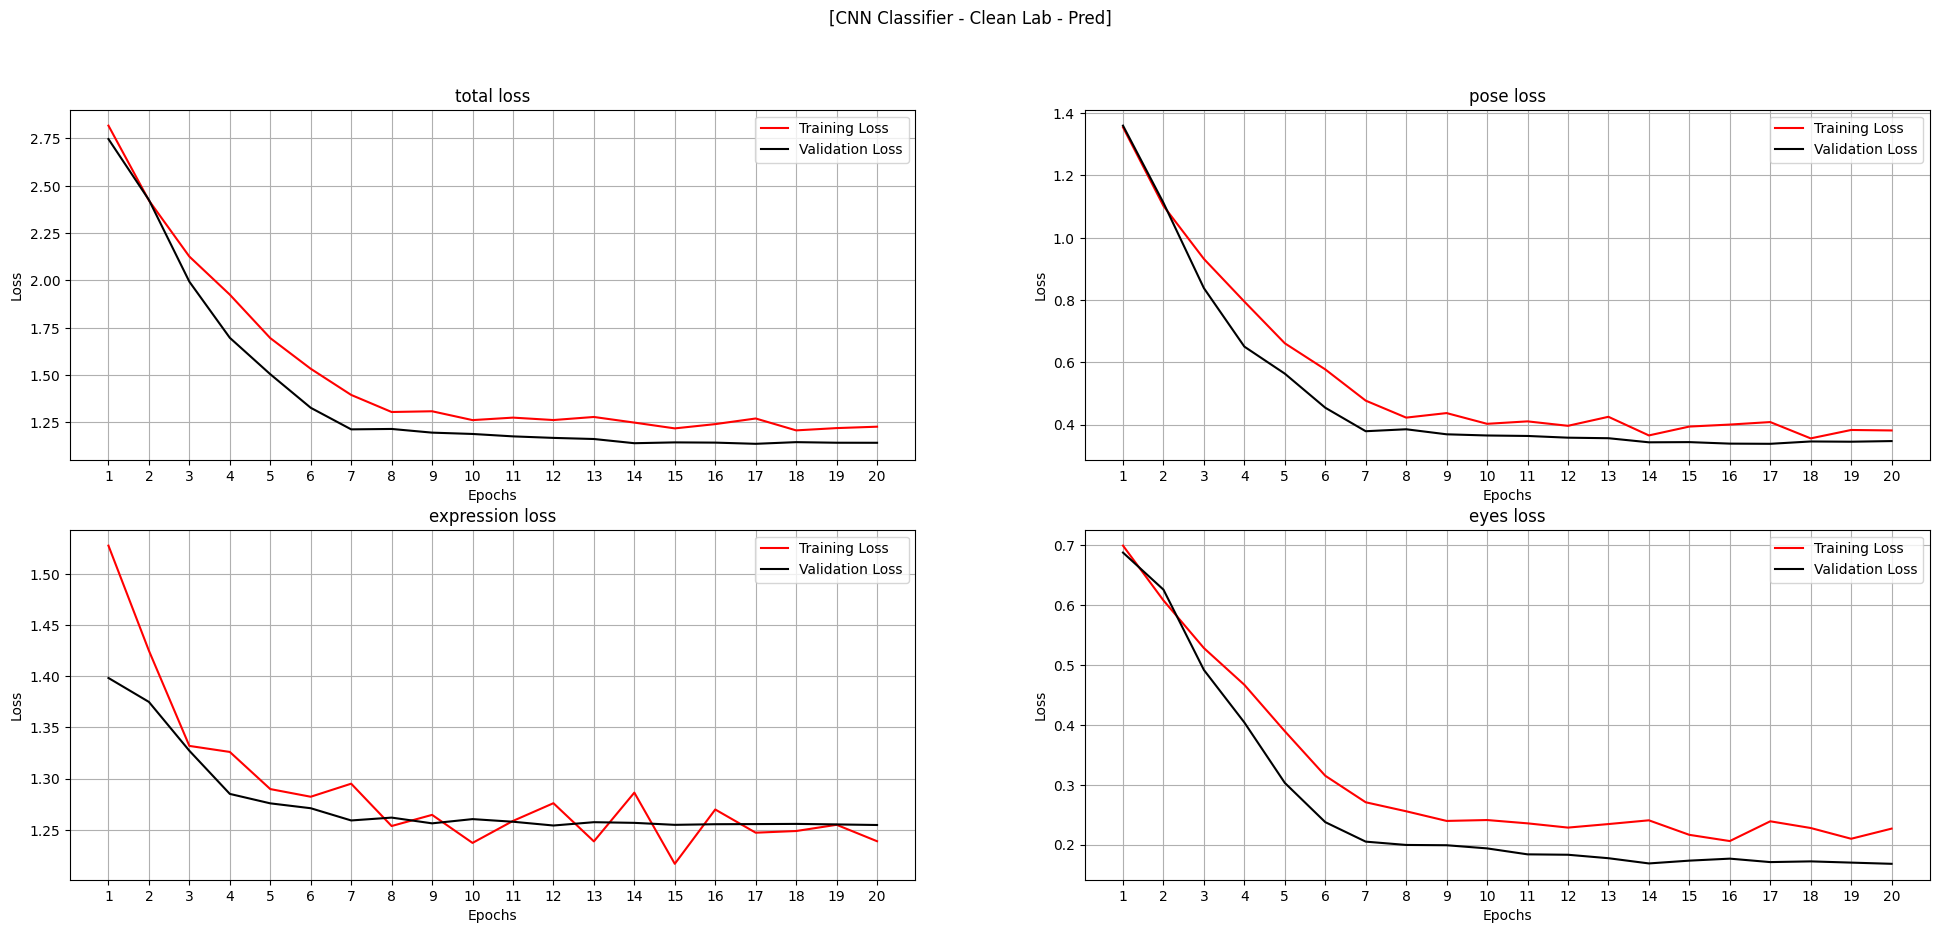

In [57]:
plot_losses(losses_cleanlab_pred, title="[CNN Classifier - Clean Lab - Pred]")

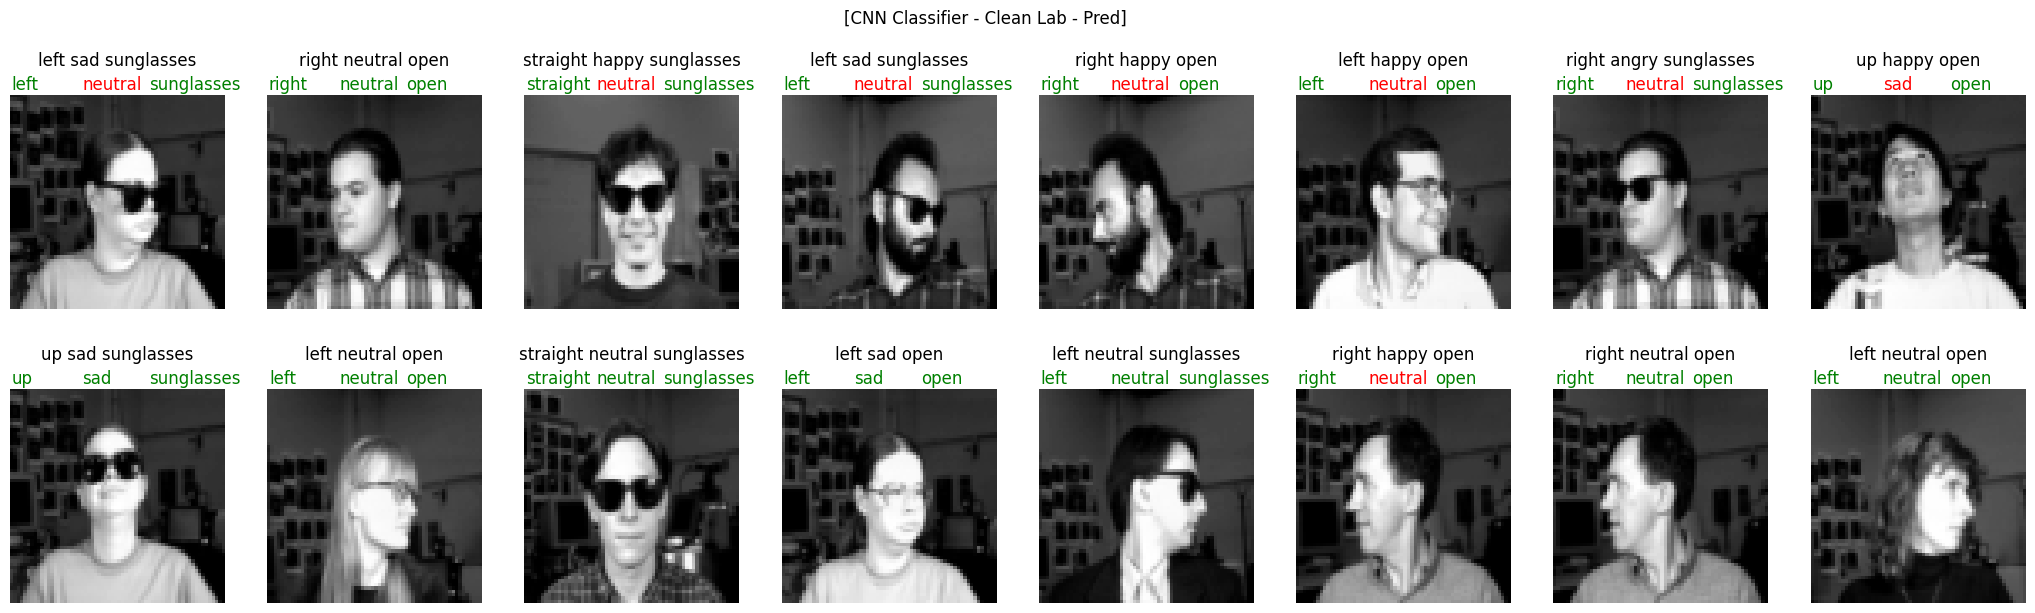

In [58]:
pred_true_cleanlab_pred = visualize_predictions(trained_model_cleanlab_pred, val_loader_cleanlab_pred,
                                                metadata_info, num_images=16, title="[CNN Classifier - Clean Lab - Pred]")

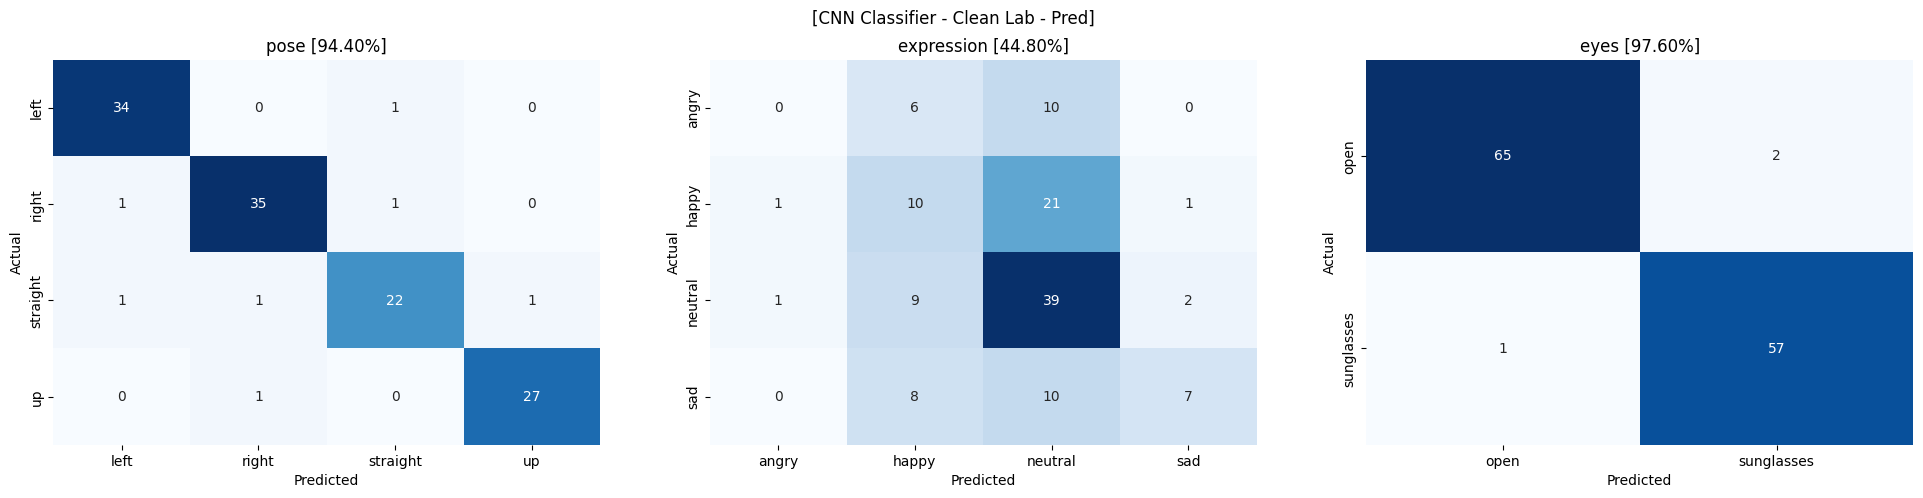

In [59]:
plot_cf_matrix(pred_true_cleanlab_pred, title="[CNN Classifier - Clean Lab - Pred]")

## ResNet50 Classifier - Clean Lab Suggested Label Pred

In [60]:
model_ft = MultiTaskResNet50(
    metadata_info['num_poses'],
    metadata_info['num_expressions'],
    metadata_info['num_eye_states']
).to(device)

In [61]:
trained_model_cleanlab_pred_ft, losses_cleanlab_pred_ft = train_model(model_ft, train_loader_cleanlab_pred_ft, val_loader_cleanlab_pred_ft,
                                                                      metadata_info, num_epochs=num_epochs, pretrained=True)

Using device: cuda

Epoch 1/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 37.98it/s]


[train loss] pose: 1.4596; expression: 1.4530; eyes: 0.7500; total: 2.9361
[train acc]  pose: 0.2605; expression: 0.3086; eyes: 0.4970



val: 100%|██████████| 4/4 [00:00<00:00, 88.79it/s]


[val loss] pose: 1.3812; expression: 1.3473; eyes: 0.6870; total: 2.7419
[val acc]  pose: 0.2720; expression: 0.4160; eyes: 0.5360

Epoch 2/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.11it/s]


[train loss] pose: 1.3386; expression: 1.4070; eyes: 0.6673; total: 2.7094
[train acc]  pose: 0.3627; expression: 0.3387; eyes: 0.5992



val: 100%|██████████| 4/4 [00:00<00:00, 88.98it/s]


[val loss] pose: 1.3937; expression: 1.3440; eyes: 0.6989; total: 2.7646
[val acc]  pose: 0.2720; expression: 0.3360; eyes: 0.4560

Epoch 3/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.09it/s]


[train loss] pose: 1.2699; expression: 1.3251; eyes: 0.6667; total: 2.5992
[train acc]  pose: 0.4068; expression: 0.3948; eyes: 0.5952



val: 100%|██████████| 4/4 [00:00<00:00, 88.35it/s]


[val loss] pose: 1.3720; expression: 1.3225; eyes: 0.7054; total: 2.7386
[val acc]  pose: 0.3040; expression: 0.4160; eyes: 0.4720

Epoch 4/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 40.68it/s]


[train loss] pose: 1.1906; expression: 1.3146; eyes: 0.6086; total: 2.4564
[train acc]  pose: 0.4629; expression: 0.4248; eyes: 0.6693



val: 100%|██████████| 4/4 [00:00<00:00, 89.44it/s]


[val loss] pose: 1.3317; expression: 1.3080; eyes: 0.6765; total: 2.6622
[val acc]  pose: 0.3440; expression: 0.4160; eyes: 0.5520

Epoch 5/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.18it/s]


[train loss] pose: 1.1184; expression: 1.2787; eyes: 0.5729; total: 2.3307
[train acc]  pose: 0.5391; expression: 0.4048; eyes: 0.7014



val: 100%|██████████| 4/4 [00:00<00:00, 89.73it/s]


[val loss] pose: 1.1915; expression: 1.2560; eyes: 0.6037; total: 2.4232
[val acc]  pose: 0.5120; expression: 0.4080; eyes: 0.7040

Epoch 6/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.21it/s]


[train loss] pose: 1.0266; expression: 1.2847; eyes: 0.5274; total: 2.1963
[train acc]  pose: 0.6072; expression: 0.4048; eyes: 0.7415



val: 100%|██████████| 4/4 [00:00<00:00, 88.77it/s]


[val loss] pose: 1.0889; expression: 1.2647; eyes: 0.5435; total: 2.2648
[val acc]  pose: 0.6400; expression: 0.4160; eyes: 0.7520

Epoch 7/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.15it/s]


[train loss] pose: 0.9184; expression: 1.2359; eyes: 0.5032; total: 2.0395
[train acc]  pose: 0.6914; expression: 0.4269; eyes: 0.7675



val: 100%|██████████| 4/4 [00:00<00:00, 88.85it/s]


[val loss] pose: 1.0238; expression: 1.2560; eyes: 0.5180; total: 2.1698
[val acc]  pose: 0.6480; expression: 0.4080; eyes: 0.7840

Epoch 8/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.29it/s]


[train loss] pose: 0.8696; expression: 1.2503; eyes: 0.4768; total: 1.9715
[train acc]  pose: 0.7295; expression: 0.4429; eyes: 0.7675



val: 100%|██████████| 4/4 [00:00<00:00, 88.60it/s]


[val loss] pose: 1.0121; expression: 1.2570; eyes: 0.5198; total: 2.1605
[val acc]  pose: 0.6400; expression: 0.4000; eyes: 0.7920

Epoch 9/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.17it/s]


[train loss] pose: 0.9010; expression: 1.2457; eyes: 0.4785; total: 2.0023
[train acc]  pose: 0.6894; expression: 0.4349; eyes: 0.7796



val: 100%|██████████| 4/4 [00:00<00:00, 88.82it/s]


[val loss] pose: 1.0143; expression: 1.2572; eyes: 0.5092; total: 2.1520
[val acc]  pose: 0.6480; expression: 0.4000; eyes: 0.7920

Epoch 10/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.38it/s]


[train loss] pose: 0.8603; expression: 1.2091; eyes: 0.4555; total: 1.9204
[train acc]  pose: 0.7214; expression: 0.4509; eyes: 0.8216



val: 100%|██████████| 4/4 [00:00<00:00, 89.33it/s]


[val loss] pose: 1.0045; expression: 1.2574; eyes: 0.5153; total: 2.1486
[val acc]  pose: 0.6720; expression: 0.4000; eyes: 0.7600

Epoch 11/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.19it/s]


[train loss] pose: 0.8402; expression: 1.2187; eyes: 0.4572; total: 1.9068
[train acc]  pose: 0.7194; expression: 0.4649; eyes: 0.8096



val: 100%|██████████| 4/4 [00:00<00:00, 89.17it/s]


[val loss] pose: 0.9930; expression: 1.2674; eyes: 0.5112; total: 2.1378
[val acc]  pose: 0.6720; expression: 0.3920; eyes: 0.7680

Epoch 12/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.26it/s]


[train loss] pose: 0.8501; expression: 1.2343; eyes: 0.4500; total: 1.9172
[train acc]  pose: 0.7034; expression: 0.4569; eyes: 0.8076



val: 100%|██████████| 4/4 [00:00<00:00, 89.13it/s]


[val loss] pose: 1.0062; expression: 1.2540; eyes: 0.5027; total: 2.1358
[val acc]  pose: 0.6640; expression: 0.4080; eyes: 0.8080

Epoch 13/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.27it/s]


[train loss] pose: 0.8455; expression: 1.2715; eyes: 0.4468; total: 1.9280
[train acc]  pose: 0.6994; expression: 0.4028; eyes: 0.8076



val: 100%|██████████| 4/4 [00:00<00:00, 88.68it/s]


[val loss] pose: 0.9823; expression: 1.2499; eyes: 0.5066; total: 2.1138
[val acc]  pose: 0.6400; expression: 0.4240; eyes: 0.8160

Epoch 14/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 40.92it/s]


[train loss] pose: 0.8194; expression: 1.1894; eyes: 0.4453; total: 1.8594
[train acc]  pose: 0.7555; expression: 0.4749; eyes: 0.8216



val: 100%|██████████| 4/4 [00:00<00:00, 89.11it/s]


[val loss] pose: 0.9620; expression: 1.2556; eyes: 0.4882; total: 2.0780
[val acc]  pose: 0.6720; expression: 0.4080; eyes: 0.8080

Epoch 15/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 40.71it/s]


[train loss] pose: 0.8381; expression: 1.2150; eyes: 0.4560; total: 1.9016
[train acc]  pose: 0.7034; expression: 0.4569; eyes: 0.7976



val: 100%|██████████| 4/4 [00:00<00:00, 88.71it/s]


[val loss] pose: 0.9706; expression: 1.2550; eyes: 0.5004; total: 2.0984
[val acc]  pose: 0.6800; expression: 0.4080; eyes: 0.7840

Epoch 16/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.15it/s]


[train loss] pose: 0.8043; expression: 1.2576; eyes: 0.4472; total: 1.8803
[train acc]  pose: 0.7395; expression: 0.4208; eyes: 0.8277



val: 100%|██████████| 4/4 [00:00<00:00, 89.03it/s]


[val loss] pose: 0.9707; expression: 1.2596; eyes: 0.4979; total: 2.0984
[val acc]  pose: 0.6720; expression: 0.4000; eyes: 0.7920

Epoch 17/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 40.89it/s]


[train loss] pose: 0.8257; expression: 1.2043; eyes: 0.4438; total: 1.8716
[train acc]  pose: 0.7214; expression: 0.4589; eyes: 0.8216



val: 100%|██████████| 4/4 [00:00<00:00, 88.66it/s]


[val loss] pose: 0.9735; expression: 1.2505; eyes: 0.5076; total: 2.1064
[val acc]  pose: 0.6960; expression: 0.4080; eyes: 0.7920

Epoch 18/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.19it/s]


[train loss] pose: 0.7978; expression: 1.2228; eyes: 0.4378; total: 1.8470
[train acc]  pose: 0.7555; expression: 0.4669; eyes: 0.8257



val: 100%|██████████| 4/4 [00:00<00:00, 89.48it/s]


[val loss] pose: 0.9973; expression: 1.2497; eyes: 0.5059; total: 2.1280
[val acc]  pose: 0.6480; expression: 0.3840; eyes: 0.7680

Epoch 19/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.21it/s]


[train loss] pose: 0.8120; expression: 1.2158; eyes: 0.4548; total: 1.8747
[train acc]  pose: 0.7315; expression: 0.4649; eyes: 0.8096



val: 100%|██████████| 4/4 [00:00<00:00, 88.66it/s]


[val loss] pose: 0.9995; expression: 1.2538; eyes: 0.5047; total: 2.1311
[val acc]  pose: 0.6160; expression: 0.3920; eyes: 0.8000

Epoch 20/20
----------


train: 100%|██████████| 16/16 [00:00<00:00, 41.39it/s]


[train loss] pose: 0.8611; expression: 1.2259; eyes: 0.4481; total: 1.9221
[train acc]  pose: 0.7054; expression: 0.4289; eyes: 0.8216



val: 100%|██████████| 4/4 [00:00<00:00, 88.12it/s]

[val loss] pose: 0.9805; expression: 1.2598; eyes: 0.5103; total: 2.1207
[val acc]  pose: 0.6720; expression: 0.3920; eyes: 0.7760

Training complete in 0m 9s


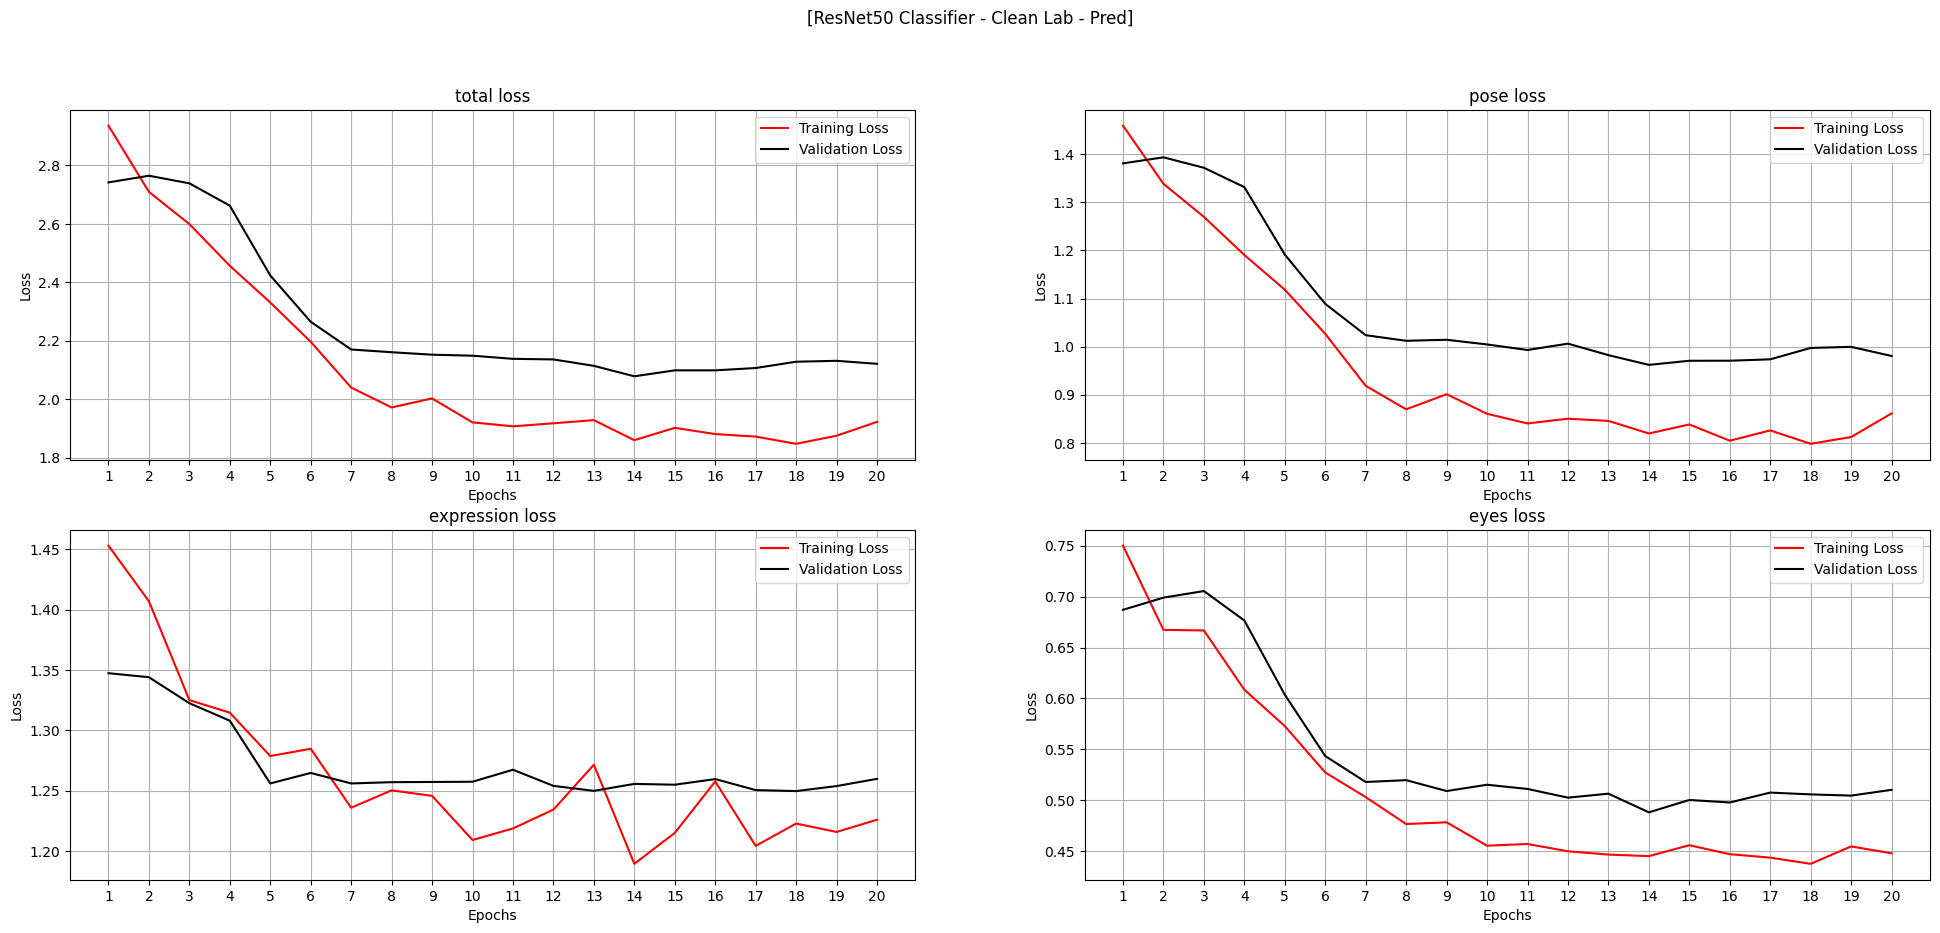

In [62]:
plot_losses(losses_cleanlab_pred_ft, title="[ResNet50 Classifier - Clean Lab - Pred]")

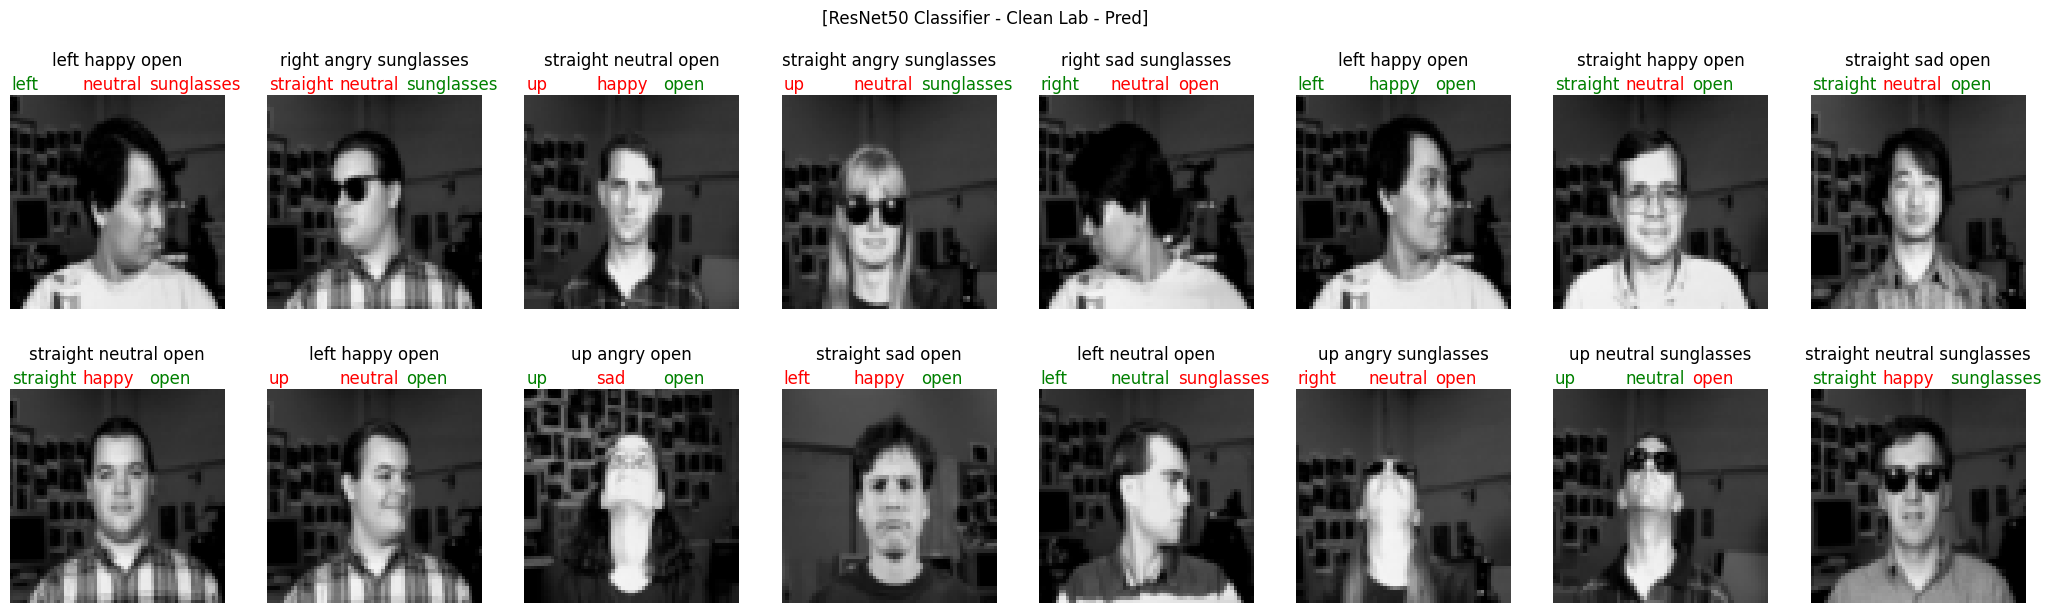

In [63]:
pred_true_cleanlab_pred_ft = visualize_predictions(trained_model_cleanlab_pred_ft, val_loader_cleanlab_pred_ft,
                                                   metadata_info, num_images=16, pretrained=True, title="[ResNet50 Classifier - Clean Lab - Pred]")

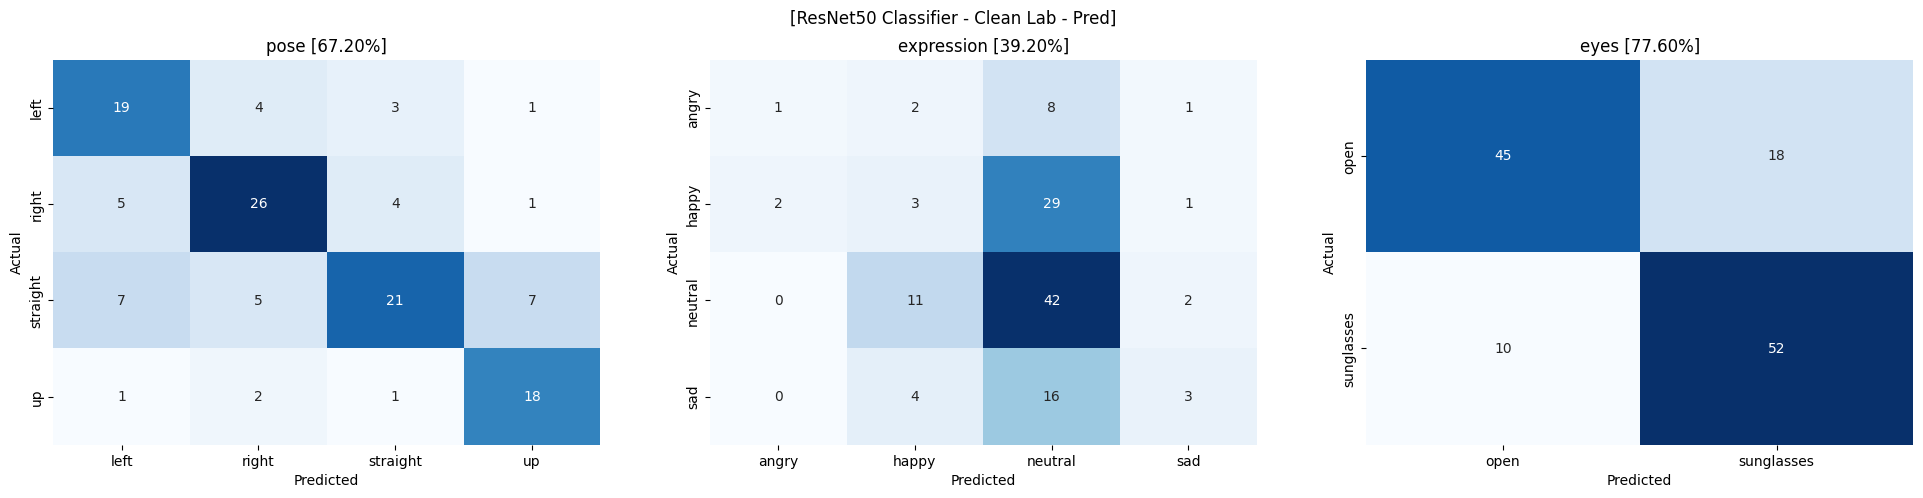

In [64]:
plot_cf_matrix(pred_true_cleanlab_pred_ft, title="[ResNet50 Classifier - Clean Lab - Pred]")